# CMIP6 Upgrade Analysis on Cheyenne

10/23/19   

This notebook builds upon CESM JSON to SQL + Outlier Detection Thesis 1.ipynb, which establishes a remote connection to a SQL database housed on AWS and populated with usage data from CESM, and prepares the data for analysis by performing outlier detection and data type confirmation using pandas. The resulting data is written as a .csv called df_NoOutlier.csv.

This notebook will analyze the effect of a system upgrade on CESM2 running on Cheyenne by looking at CMIP6 data from 2019. The upgrade shut Cheyenne down from June 25-July 5, 2019.

This notebook is called CESM Upgrade Analysis Thesis 1.ipynb (using data as of 9/10/19), and expands and refines the cursory upgrade analysis of the CESM Analysis Workbook.ipynb (with data as of 7/16/19). 

# Load Required Packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats
import statsmodels.api as sm
import pylab
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

# Acquire the Data

CSV file prepared for analysis by CESM JSON to SQL + Outlier Detection Thesis 1.ipynb.

In [2]:
#Read df_NoOutlier.csv
df_NoOutlier = pd.read_csv('df_NoOutlier-Thesis.csv', sep=',')
len(df_NoOutlier)

6085

In [3]:
df_NoOutlier.head()

Unnamed: 0                                                 Id  \
0           0   /glade/scratch/bdobbins/projects/Database/CMI...   
1           1   /glade/scratch/bdobbins/projects/Database/CMI...   
2           2   /glade/scratch/bdobbins/projects/Database/CMI...   
3           3   /glade/scratch/bdobbins/projects/Database/CMI...   
4           4   /glade/scratch/bdobbins/projects/Database/CMI...   

                                                 LID  \
0                     4142239.chadmin1.190127-015112   
1                     1220262.chadmin1.180723-102337   
2  8170274.chadmin1.ib0.cheyenne.ucar.edu.190907-...   
3                     4711042.chadmin1.190317-181426   
4  7137706.chadmin1.ib0.cheyenne.ucar.edu.190713-...   

                                            Timeroot  \
0  /glade/work/cmip6/cases/ScenarioMIP_WACCM/b.e2...   
1  /glade/work/cmip6/cases/cesm2.1-exp002/b.e21.B...   
2  /gpfs/fs1/work/cmip6/cases/GeoMIP/b.e21.BWSSP5...   
3  /gpfs/fs1/work/cmip6/cases/PAMIP/f.e21.FHIST_B...   
4  /glade/work/cmip6/cases/AerChemMIP/b.e21.BWSSP...   

                                                case  \
0  b.e21.BWSSP126cmip6.f09_g17.CMIP6-SSP1-2.6-WAC...   
1           b.e21.BW1850.f09_g17.CMIP6-piControl.001   
2  b.e21.BWSSP585cmip6.f09_g17.CMIP6-G6solar-WACC...   
3  f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-pdSST-futAn...   
4  b.e21.BWSSP370lowNTCFcmip6.f09_g17.CMIP6-SSP3-...   

                                            caseroot  comp_pes_atm  \
0  /glade/work/cmip6/cases/ScenarioMIP_WACCM/b.e2...          3456   
1  /glade/work/cmip6/cases/cesm2.1-exp002/b.e21.B...          6912   
2  /gpfs/fs1/work/cmip6/cases/GeoMIP/b.e21.BWSSP5...          3456   
3  /gpfs/fs1/work/cmip6/cases/PAMIP/f.e21.FHIST_B...          1080   
4  /glade/work/cmip6/cases/AerChemMIP/b.e21.BWSSP...          3456   

   comp_pes_cpl  comp_pes_esp  comp_pes_glc      ...       threads_ice  \
0          3456             1          3456      ...                 3   
1          6912             6          6912      ...                 6   
2          3456             1          3456      ...                 3   
3          1080             1          1080      ...                 3   
4          3456             1          3456      ...                 3   

   threads_lnd  threads_ocn  threads_rof  threads_wav total_pes_active   user  \
0            3            3            3            3            10692  cmip6   
1            6            6            6            6            42336  cmip6   
2            3            3            3            3            10692  cmip6   
3            3            3            3            3             3240  cmip6   
4            3            3            3            3            10692  cmip6   

  run_length_days run_length_years     CPU_hours  
0             365         1.000000  21599.850000  
1             365         1.000000  29654.060000  
2             365         1.000000  20213.400000  
3             426         1.167123   2595.448767  
4             365         1.000000  22805.640000  

[5 rows x 101 columns]

In [4]:
df_NoOutlier.columns

Index(['Unnamed: 0', 'Id', 'LID', 'Timeroot', 'case', 'caseroot',
       'comp_pes_atm', 'comp_pes_cpl', 'comp_pes_esp', 'comp_pes_glc',
       ...
       'threads_ice', 'threads_lnd', 'threads_ocn', 'threads_rof',
       'threads_wav', 'total_pes_active', 'user', 'run_length_days',
       'run_length_years', 'CPU_hours'],
      dtype='object', length=101)

In [5]:
#Drop Unnamed column:
del df_NoOutlier['Unnamed: 0']

In [6]:
#Data integrity check

#Summary statistics on numeric features
with pd.option_context("display.max_columns", 1000):
    display (df_NoOutlier.describe())

comp_pes_atm  comp_pes_cpl  comp_pes_esp  comp_pes_glc  comp_pes_ice  \
count   6085.000000   6085.000000   6085.000000   6085.000000   6085.000000   
mean    3014.054889   3045.286442     42.394412   2978.670173   1252.385867   
std     1603.520163   1561.744851    303.559045   1621.399896    844.495426   
min       36.000000     72.000000      1.000000      2.000000     72.000000   
25%     1728.000000   1728.000000      1.000000   1728.000000    756.000000   
50%     3456.000000   3456.000000      1.000000   3456.000000    864.000000   
75%     3456.000000   3456.000000      1.000000   3456.000000   1728.000000   
max     6912.000000   6912.000000   5400.000000   6912.000000   5400.000000   

       comp_pes_lnd  comp_pes_ocn  comp_pes_rof  comp_pes_wav   final_time  \
count   6085.000000   6085.000000   6085.000000   6085.000000  6085.000000   
mean    2383.880362    751.450288   2373.830731    555.012325     0.035464   
std     1111.569218    814.437839   1127.967467    837.436635     0.159572   
min       72.000000     72.000000     72.000000      2.000000     0.001000   
25%     1728.000000    108.000000   1728.000000     96.000000     0.006000   
50%     2592.000000    751.000000   2592.000000    108.000000     0.023000   
75%     2592.000000   1080.000000   2592.000000   1080.000000     0.044000   
max     5400.000000   5400.000000   5400.000000   5400.000000    10.665000   

       init_time_seconds  instances_atm  instances_cpl  instances_esp  \
count        6085.000000         6085.0         6085.0         6085.0   
mean          113.706535            1.0            1.0            1.0   
std            82.791614            0.0            0.0            0.0   
min             5.326000            1.0            1.0            1.0   
25%            71.665000            1.0            1.0            1.0   
50%            90.143000            1.0            1.0            1.0   
75%           125.522000            1.0            1.0            1.0   
max          1821.473000            1.0            1.0            1.0   

       instances_glc  instances_ice  instances_lnd  instances_ocn  \
count         6085.0         6085.0         6085.0         6085.0   
mean             1.0            1.0            1.0            1.0   
std              0.0            0.0            0.0            0.0   
min              1.0            1.0            1.0            1.0   
25%              1.0            1.0            1.0            1.0   
50%              1.0            1.0            1.0            1.0   
75%              1.0            1.0            1.0            1.0   
max              1.0            1.0            1.0            1.0   

       instances_rof  instances_wav    model_cost  model_throughput  \
count         6085.0         6085.0   6085.000000       6085.000000   
mean             1.0            1.0  12892.249898         13.314846   
std              0.0            0.0  10309.426761         15.874284   
min              1.0            1.0    259.520000          2.030000   
25%              1.0            1.0   2809.230000          4.090000   
50%              1.0            1.0   6661.490000          7.930000   
75%              1.0            1.0  21204.810000         18.020000   
max              1.0            1.0  46640.970000        169.790000   

       ocn_init_wait_time     pe_count  pes_per_node  root_pe_atm  \
count         6085.000000  6085.000000        6085.0       6085.0   
mean          5570.021949  3339.113887          36.0          0.0   
std           5665.834416  1658.425369           0.0          0.0   
min              0.000000   720.000000          36.0          0.0   
25%             97.044000  1728.000000          36.0          0.0   
50%           4962.940000  3564.000000          36.0          0.0   
75%           9208.409000  4320.000000          36.0          0.0   
max          32662.574000  7056.000000          36.0          0.0   

       root_pe_cpl  root_pe_esp  root_pe_glc  root

# Subset by Case and Ensemble Group

There are a variety of different suffixes on cases, such as .001, .002, etc. which typically identify ensemble runs that are the same case with different starting conditions (slightly perturbed). We could analyze post-upgrade performance by case, and also by ensemble. Ensemble grouping is determined by dropping the suffix from the case (which I will name 'BaseCase').

Going forward, the dataframe of all the case names from df_NoOutlier will be called df_CaseSpan. The cases may be run more than once in a series of resbumits, so the same case can appear multiple times in the df.

The dataframe with all the case names minus the suffix will be called df_BaseSpan.

Below I will parse out the ensembles and do some basic EDA.

## Unique Cases

In [7]:
#Count unique cases
print("Unique Cases:", len(df_NoOutlier.case.unique()))

Unique Cases: 948


The reason there are only 948 unique cases amongst 6000+ entries is due to restarts, i.e., cases that have to be run in shorter chunks according to CPU allotment.  

Glance at the number of submits per case:

In [8]:
#Create df_cases

#Count the frequency of each case, sort by ascending counts, and put into the series into df_cases
#Convert the series to a dataframe
df_Cases = df_NoOutlier['case'].value_counts(sort=True, ascending=False).to_frame().reset_index()
#Set column names
df_Cases.columns = ["Case","Submits"]
df_Cases 

Case  Submits
0             b.e21.BW1850.f09_g17.CMIP6-piControl.001      340
1    b.e21.BWaerchem-piNTCF.f09_g17.CMIP6-hist-piNT...      165
2    f.e21.FWaerchem-piCH4.f09_g17.CMIP6-histSST-pi...      165
3    f.e21.FWaerchem-histSST.f09_g17.CMIP6-histSST-...      163
4    f.e21.FWaerchem-piNTCF.f09_g17.CMIP6-histSST-p...      159
5         b.e21.BW1PCT.f09_g17.CMIP6-1pctCO2-WACCM.001      149
6    b.e21.BWCO2x4.f09_g17.CMIP6-abrupt4xCO2-WACCM.001      148
7    b.e21.B1850G.f09_g17_gl4.CMIP6-piControl-withi...      131
8              b.e21.B1850.f09_g17.CMIP6-piControl.001      121
9      b.e21.BWHIST.f09_g17.CMIP6-historical-WACCM.002      118
10     b.e21.BWHIST.f09_g17.CMIP6-historical-WACCM.003      110
11         b.e21.B1850.f09_g17.CMIP6-esm-piControl.001      100
12     b.e21.BCO2x4cmip6.f09_g17.CMIP6-abrupt4xCO2.001      100
13     b.e21.BWHIST.f09_g17.CMIP6-historical-WACCM.001      100
14            b.e21.BWCO2x4.f09_g17.CMIP6-G1-WACCM.001      100
15   b.e21.BWSSP245cmip6.f09_g17.CMIP6-SSP2-4.5-WAC...       90
16   b.e21.BWSSP370cmip6.f09_g17.CMIP6-SSP3-7.0-WAC...       89
17   b.e21.BWSSP585cmip6.f09_g17.CMIP6-SSP5-8.5-WAC...       87
18   b.e21.BWSSP126cmip6.f09_g17.CMIP6-SSP1-2.6-WAC...       86
19   b.e21.BWSSP585cmip6.f09_g17.CMIP6-G6solar-WACC...       83
20   b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-wit...       71
21                 b.e21.B1850.f09_g17.PMIP4-127ka.001       71
22               b.e21.B1850.f09_g17.PMIP4-midHolo.001       70
23   b.e21.BWCO2x4.f09_g17.CMIP6-abrupt4xCO2-WACCM....       68
24   b.e21.BWma1850.f19_g17.CMIP6-piControl-WACCM-M...       65
25   f.e21.FWaerchem-1950HC.f09_g17.CMIP6-hist-1950...       65
26   b.e21.BWaerchem-1950HC.f09_g17.CMIP6-hist-1950...       65
27   b.e21.BWSSP534oscmip6.f09_g17.CMIP6-SSP5-3.4OS...       61
28   f.e21.FWHISTBgcCrop.f09_f09_mg17.CMIP6-AMIP-WA...       51
29   b.e21.BWSSP585cmip6.f09_g17.CMIP6-G6solar-WACC...       51
..                                                 ...      ...
918  f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-futSST-pdSI...        1
919  f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-pdSST-futAn...        1
920  f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-pdSST-piAnt...        1
921  f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-futSST-pdSI...        1
922  f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-pdSST-pdSIC...        1
923  f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-pdSST-pdSIC...        1
924  f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-piSST-pdSIC...        1
925  f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-pdSST-futAn...        1
926  f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-piSST-piSIC...        1
927  f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-pdSST-pdSIC...        1
928  f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-piSST-piSIC...        1
929  f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-pdSST-futAr...        1
930  f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-pdSST-piAnt...        1
931  f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-pdSST-futAr...        1
932  f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-pdSST-futAr...        1
933  f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-piSST-pdSIC...        1
934  f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-pdSST-futAn...        1
935    b.e21.BHIST.f09_g17.CMIP6-pa-futArcSIC_TEST.001        1
936  f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-pdSST-piArc...        1
937  f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-piSST-piSIC...        1
938  f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-piSST-pdSIC...        1
939  f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-futSST-pdSI...        1
940  f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-pdSST-piAnt...        1
941  f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-pdSST-piAnt...        1
942  f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-piSST-pdSIC...        1
943  f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-pdSST-piAnt...        1
944  f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-pdSST-pdSIC...        1
945  f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-pdSST-piArc...        1
946  f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-futSST-pdSI...        1
947  f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-pdSST-futAn...        1

[948 rows x 2 columns]

In [9]:
#Confirm
len(df_Cases)

948

## Examine Ensembles

To examine the ensemble names, I first have to parse out the case string and learn more about how it is constructed:

In [10]:
#Parse the case string out by "." and put the values into columns to look at (expand = True)

with pd.option_context("display.max_rows", 1000):
    display(df_NoOutlier.case.str.split(pat = ".", expand=True).head(10))

0    1                     2             3                        4  \
0  b  e21         BWSSP126cmip6       f09_g17             CMIP6-SSP1-2   
1  b  e21                BW1850       f09_g17          CMIP6-piControl   
2  b  e21         BWSSP585cmip6       f09_g17      CMIP6-G6solar-WACCM   
3  f  e21             FHIST_BGC  f09_f09_mg17    CMIP6-pdSST-futAntSIC   
4  b  e21  BWSSP370lowNTCFcmip6       f09_g17             CMIP6-SSP3-7   
5  b  e21               BWCO2x4       f09_g17  CMIP6-abrupt4xCO2-WACCM   
6  b  e21                 B1850       f09_g17          CMIP6-piControl   
7  b  e21                B1850G   f09_g17_gl4  CMIP6-piControl-withism   
8  b  e21                 BHIST       f19_g17    CMIP6-historical-2deg   
9  f  e21             FHIST_BGC  f09_f09_mg17              CMIP6-GMMIP   

                 5     6     7  
0          6-WACCM   001  None  
1              001  None  None  
2              002  None  None  
3              096  None  None  
4  0-lowNTCF-WACCM   002  None  
5              001  None  None  
6              001  None  None  
7              001  None  None  
8              001  None  None  
9              002  None  None

The string split above shows that the "." separated case strings are not always of the same length. Some have 5 parts, some have 6 or 7. So, let's look at the typical length of a case string by counting the number of components in all the strings:

In [11]:
#Since the case names aren't always of the same length,
#What is the breakdown of each string?

#Put the case parsing into a dataframe to look at those last few columns
df_CaseParse = df_NoOutlier.case.str.split(pat = ".", expand=True)
cols = ['case0', 'case1', 'case2', 'case3', 'case4', 'case5', 'case6', 'case7']
df_CaseParse.columns = cols
df_CaseParse.describe()

case0 case1      case2    case3            case4 case5 case6 case7
count   6085  6085       6085     6085             6085  6085   965    18
unique     4     1         42        6               87   128     6     1
top        b   e21  FHIST_BGC  f09_g17  CMIP6-piControl   001   001   001
freq    3806  6085       1034     4077              489  3442   643    18

All of the case strings go out to five components, and some to six, and just a few to seven. Now let's examine the unique suffixes:

In [12]:
#Look at unique suffixes and put into a column called CaseSuffix in df_NoOutlier:

#Creating new column with last element in df_NoOutlier
df_NoOutlier["CaseSuffix"]= df_NoOutlier["case"].str.split(".").str[-1]
df_NoOutlier['CaseSuffix'].unique()

array(['001', '002', '096', '041', '011', '001b', '003', '004', '077',
       '067', '040', '005', '088', '012', '010', '009', '042', '027',
       '010_test', '098', '032', '019', '006', '063', '070', '025', '068',
       '082', '081', '061', '045', '029', '001c', '007', '057',
       '001_WACCM_y70', '014', '044', '092', '047', '095', '072', '062',
       '008', '064', '034', '030', '021', '099', '091', '043', '015',
       'glacier', '005_CONTINUE', '036', '031', '074', '039', '083',
       '001_CONTINUE', '016', '059', '089', '071', '001_cosp', '013',
       '097', '033', '084', '085', '078', '048', '076', '018', '058',
       '028', '069', '017', '065', '073', '037', '022', '087', '023',
       '060', '052', '055', '024', '054', '079', '026', '053', '051',
       '038', '093', '080', '056', '075', '100', '020', '066',
       '001_yr131', '046', '050', '086', '049', '035', '009_CONTINUE',
       '090', '094', '001_nocosp', '007_CONTINUE', '006_CONTINUE',
       '008_CONTINUE'], dty

Some suffixes contain numerals in the form .xxx, some are .xxx_CONTINUE, and another is .glacier. Hopefully I can hear more about suffixes from one of the scientists. To get the ensemble name, a feature that I will call BaseCase, I'll right-partition the case string and take the first element (in effect, dropping the suffix):

In [13]:
#Drop suffix on case and put in column called BaseCase

df_NoOutlier['BaseCase'] = df_NoOutlier.case.str.rpartition('.')[0]

with pd.option_context("display.max_colwidth", 1000):
    display(df_NoOutlier.BaseCase)

0                             b.e21.BWSSP126cmip6.f09_g17.CMIP6-SSP1-2.6-WACCM
1                                         b.e21.BW1850.f09_g17.CMIP6-piControl
2                              b.e21.BWSSP585cmip6.f09_g17.CMIP6-G6solar-WACCM
3                           f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-pdSST-futAntSIC
4              b.e21.BWSSP370lowNTCFcmip6.f09_g17.CMIP6-SSP3-7.0-lowNTCF-WACCM
5                                b.e21.BWCO2x4.f09_g17.CMIP6-abrupt4xCO2-WACCM
6                                          b.e21.B1850.f09_g17.CMIP6-piControl
7                             b.e21.B1850G.f09_g17_gl4.CMIP6-piControl-withism
8                                    b.e21.BHIST.f19_g17.CMIP6-historical-2deg
9                                     f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-GMMIP
10                              f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-pdSST-pdSIC
11                   f.e21.FWaerchem-piNTCF.f09_g17.CMIP6-histSST-piNTCF-WACCM
12                     f.e21.FWaerchem-piCH4.f09_g17

## Unique Bases

Find the number of unique BaseCases and look at the number of submits:

In [14]:
#How many unique BaseCases?
len(df_NoOutlier.BaseCase.unique())

101

Glance at BaseCase submits:

In [15]:
#df_BaseCases  
df_BaseCases = df_NoOutlier['BaseCase'].value_counts(sort=True, ascending=False).to_frame().reset_index()
#Set column names
df_BaseCases.columns = ["BaseCase","Submits"]
df_BaseCases

BaseCase  Submits
0                 b.e21.BW1850.f09_g17.CMIP6-piControl      343
1          b.e21.BWHIST.f09_g17.CMIP6-historical-WACCM      328
2                 b.e21.BHIST.f09_g17.CMIP6-historical      218
3     b.e21.BWSSP370cmip6.f09_g17.CMIP6-SSP3-7.0-WACCM      171
4    f.e21.FWaerchem-piCH4.f09_g17.CMIP6-histSST-pi...      165
5    b.e21.BWaerchem-piNTCF.f09_g17.CMIP6-hist-piNT...      165
6    f.e21.FWaerchem-histSST.f09_g17.CMIP6-histSST-...      163
7    f.e21.FWaerchem-piNTCF.f09_g17.CMIP6-histSST-p...      159
8             b.e21.BW1PCT.f09_g17.CMIP6-1pctCO2-WACCM      149
9        b.e21.BWCO2x4.f09_g17.CMIP6-abrupt4xCO2-WACCM      148
10     b.e21.BWSSP585cmip6.f09_g17.CMIP6-G6solar-WACCM      139
11   f.e21.FWHISTBgcCrop.f09_f09_mg17.CMIP6-AMIP-WACCM      135
12    b.e21.B1850G.f09_g17_gl4.CMIP6-piControl-withism      131
13                 b.e21.B1850.f09_g17.CMIP6-piControl      126
14    b.e21.BWSSP585cmip6.f09_g17.CMIP6-SSP5-8.5-WACCM      125
15   b.e21.BWSSP370lowNTCFcmip6.f09_g17.CMIP6-SSP3-...      124
16         b.e21.BCO2x4cmip6.f09_g17.CMIP6-abrupt4xCO2      108
17      f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-pdSST-pdSIC      101
18     f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-futSST-pdSIC      100
19   f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-pdSST-futAn...      100
20      f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-piSST-pdSIC      100
21             b.e21.B1850.f09_g17.CMIP6-esm-piControl      100
22                b.e21.BWCO2x4.f09_g17.CMIP6-G1-WACCM      100
23   f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-pdSST-futAr...      100
24   f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-pdSST-piAntSIC      100
25   f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-pdSST-piArcSIC      100
26      f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-piSST-piSIC      100
27    b.e21.BWSSP245cmip6.f09_g17.CMIP6-SSP2-4.5-WACCM       90
28            f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-GMMIP       87
29    b.e21.BWSSP126cmip6.f09_g17.CMIP6-SSP1-2.6-WACCM       86
..                                                 ...      ...
71            f.e21.F1850_BGC.f09_f09_mg17.CFMIP-a4SST       15
72         f.e21.F1850_BGC.f09_f09_mg17.CFMIP-a4SSTice       15
73                   b.e21.B1PCT.f09_g17.CMIP6-1pctCO2       15
74               b.e21.B1PCT.f09_g17.CMIP6-1pctCO2-bgc       15
75   f.e21.F1850_BGC.f09_f09_mg17.CMIP6-RFMIP-ERF-4...       10
76     b.e21.B1850.f09_g17.CMIP6-piControl.001_wetland       10
77   f.e21.F1850_BGC.f09_f09_mg17.CMIP6-RFMIP-ERF-a...       10
78   f.e21.F1850_BGC.f09_f09_mg17.CMIP6-RFMIP-ERF-p...       10
79     f.e21.F1850_BGC.f09_f09_mg17.CMIP6-RFMIP-ERF-lu       10
80   f.e21.F1850_BGC.f09_f09_mg17.CMIP6-RFMIP-ERF-a...       10
81     b.e21.B1850.f09_g17.CMIP6-piControl.002_wetland       10
82    f.e21.F1850_BGC.f09_f09_mg17.CMIP6-RFMIP-ERF-ghg       10
83   b.e21.BSSP126cmip6.f09_g17.CMIP6-SSP1-2.6-SSP3...        9
84         i.e21.IHIST.f09_g17.CMIP6-land-hist-cruNcep        9
85          i.e21.IHIST.f09_g17.CMIP6-land-crop-noFert        9
86   b.e21.BSSP370cmip6.f09_g17.CMIP6-SSP3-7.0-SSP1...        9
87           i.e21.IHIST.f09_g17.CMIP6-land-noWoodHarv        9
88                i.e21.IHIST.f09_g17.CMIP6-land-cClim        9
89                 i.e21.IHIST.f09_g17.CMIP6-land-hist        9
90       i.e21.IHIST.f09_g17.CMIP6-land-hist-princeton        9
91                 i.e21.IHIST.f09_g17.CMIP6-land-cCO2        9
92               i.e21.IHIST.f09_g17.CMIP6-land-noFire        9
93            b.e21.B1850.f09_g17.CMIP6-deforest-globe        8
94        b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2-4xext        5
95            f.e21.QPC6.f09_f09_mg17.CFMIP-aqua-4xCO2        5
96          f.e21.QPC6.f09_f09_mg17.CFMIP-aqua-control        5
97              f.e21.QPC6.f09_f09_mg17.CFMIP-aqua-p4K        5
98             b.e21.BHIST.f09_g17.CMIP6-pa-pdSIC_TEST        2
99         b.e21.BHIST.f09_g17.CMIP6-pa-futArcSIC_TEST        1
100         b.e21.BHIST.f09_g17.CMIP6-pa-piArcSIC_TEST        1

[101 rows x 2 columns]

# Crossing the Upgrade Gap

The goal of this analysis is to compare CESM2 performance before and after the system upgrade on Cheyenne, which occured June 25-July 5, 2019. The comparison will take a three-pronged approach:  
  
-Compare before/after performance on exact case matches  
-Compare before/after performance on exact ensemble matches (BaseCases)   
-Take a wider swath by grouping by atmospheric component, atmospheric processor count, and ocean processor count, then comparing before/after performance. This part is handled in ATM Component Analysis Thesis 1.ipynb

## Subsetting by System Upgrade Date

Verify dates of upgrade, which we know was around the end of June/beginning of July 2019

In [16]:
#Look to find the gap in dates when Cheyenne was offline:
df_NoOutlier.loc[(df_NoOutlier.curr_date <= '2019-07-07') & (df_NoOutlier.curr_date >= '2019-06-23')].curr_date.unique()

array(['2019-07-06 11:19:31', '2019-06-23 10:04:36',
       '2019-06-23 03:25:18', '2019-06-23 05:11:35',
       '2019-07-06 04:29:35', '2019-06-23 19:03:37',
       '2019-06-23 12:45:58', '2019-06-23 18:18:57',
       '2019-06-23 23:05:36', '2019-06-23 01:15:11',
       '2019-07-06 18:11:20', '2019-06-23 14:02:49',
       '2019-06-23 06:44:04', '2019-06-23 00:40:54',
       '2019-06-24 01:40:35', '2019-06-23 11:50:56',
       '2019-07-06 18:07:56', '2019-07-06 07:51:39',
       '2019-07-06 18:10:06', '2019-06-23 21:10:34',
       '2019-06-23 16:20:24', '2019-07-06 04:31:24',
       '2019-06-23 11:08:37', '2019-06-23 18:50:11',
       '2019-06-23 13:08:51', '2019-06-23 07:08:17',
       '2019-06-23 02:34:43', '2019-06-23 01:13:56',
       '2019-07-06 17:39:43', '2019-07-06 04:22:24',
       '2019-06-23 09:52:19', '2019-06-23 21:03:46',
       '2019-06-23 14:33:07', '2019-07-06 11:19:20',
       '2019-07-06 18:08:29', '2019-06-23 08:36:11',
       '2019-06-23 07:47:42', '2019-06-23 19:1

Only one case ran early on June 24th, then there is a gap until they started running again on July 6th.

## Subset Cases that Span the Upgrade (df_CaseSpan) 

Many cases ran before or after the upgrade, but not both. To compare the exact cases that spanned the upgrade, we need to get a list of those cases:

In [17]:
#Subset by before and after the upgrade (the system was down from June 25 to July 5, 2019)

#Create df of cases before the upgrade
df_before_all = df_NoOutlier[df_NoOutlier.curr_date <= '2019-07-01']
#Make a list of all before cases
before_cases = df_before_all.case

#Create df of cases after the upgrade
df_after_all = df_NoOutlier[df_NoOutlier.curr_date >= '2019-07-01']
#Make a list of all after cases
after_cases = df_after_all.case

#Match the lists 
Case_List = set(before_cases).intersection(after_cases)
len(Case_List)

14

In [18]:
Case_List

{'b.e21.B1850.f09_g17.CMIP6-DAMIP-hist-nat.002',
 'b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001',
 'b.e21.B1850G.f09_g17_gl4.CMIP6-piControl-withism.001',
 'b.e21.BSSP585_BPRPcmip6.f09_g17.CMIP6-esm-ssp585-ssp126-Lu.001',
 'b.e21.BWCO2x4.f09_g17.CMIP6-G1-WACCM.001',
 'b.e21.BWSSP370cmip6.f09_g17.CMIP6-SSP3-7.0-WACCM.002',
 'b.e21.BWSSP370cmip6.f09_g17.CMIP6-SSP3-7.0-WACCM.003',
 'f.e21.F1850_BGC.f09_f09_mg17.CFMIP-piSST.001',
 'f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-GMMIP.001',
 'f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-GMMIP.003',
 'f.e21.FWaerchem-piCH4.f09_g17.CMIP6-histSST-piCH4-WACCM.001',
 'g.e21.GOMIPECOIAF.T62_g17.CMIP6-omip1.001',
 'g.e21.GOMIPECOIAF.T62_g17.CMIP6-omip1.002',
 'g.e21.GOMIPECOIAF_JRA.TL319_g17.CMIP6-omip2.001'}

In [19]:
#Subset df_NoOutlier based on Case_List
df_CaseSpan = df_NoOutlier[df_NoOutlier['case'].isin(Case_List)] 
df_CaseSpan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 811 entries, 7 to 6020
Columns: 102 entries, Id to BaseCase
dtypes: float64(20), int64(58), object(24)
memory usage: 652.6+ KB


We have 14 unique spanning cases, and 811 runs.

In [20]:
#Change curr_date to datetime format
#For some reason this setting got lost between the read/write from SQL
df_CaseSpan['curr_date'] = pd.to_datetime(df_CaseSpan.curr_date)

#Check that all dates are in 2019
df_CaseSpan['curr_date'].describe()

count                     811
unique                    811
top       2019-07-14 20:28:08
freq                        1
first     2019-04-04 21:52:49
last      2019-09-09 15:10:44
Name: curr_date, dtype: object

The dates for df_CaseSpan range from April to September, 2019.

In [21]:
#Create a Week of the year column
df_CaseSpan['Week'] = df_CaseSpan.curr_date.dt.week
#Check the week distribution of df_CaseSpan:
with pd.option_context("display.max_rows", 1000):
    display(df_CaseSpan[['Week']].sort_values('Week'))

Week
4277    14
3961    14
4445    14
1968    14
4077    17
3517    17
1753    17
1752    17
5602    17
4730    17
5822    18
4005    18
170     18
2715    18
2236    18
1389    18
2448    18
281     18
5731    18
690     18
2335    18
3266    18
13      18
4778    18
4168    18
4141    19
4227    19
2339    19
1790    19
3780    19
5722    19
4843    19
827     20
5372    20
5363    20
5235    20
1099    20
5711    20
1107    20
5697    20
1874    20
456     20
2112    20
4732    20
4715    20
2038    20
4450    20
1997    20
1834    20
1179    20
7       20
325     20
5526    20
3104    20
6008    20
2833    20
2766    20
56      20
2692    20
3614    20
3803    20
235     20
212     20
238     20
2547    20
5771    20
5757    20
3597    20
2367    20
38      20
3031    20
864     21
3649    21
5413    21
1071    21
5458    21
5153    21
5017    21
4295    21
4776    21
2969    21
4304    21
1674    21
3993    21
2660    21
4042    21
1942    21
4105    21
4140    21
4428    21
2384    21
2984    21
3829    21
1741    21
254     21
2033    22
982     22
3535    22
1772    22
3336    22
5370    22
4488    22
1551    22
1679    22
5551    22
4966    22
4678    22
3641    22
4190    22
1169    22
1882    22
2012    22
3737    22
4603    22
4302    22
484     22
3692    22
5495    22
5544    22
2213    22
3918    22
583     22
5870    22
1497    22
2287    22
1998    23
2800    23
4110    23
2989    23
4607    23
1364    23
4487    23
3785    23
2729    23
119     23
5986    23
2519    23
93      23
3587    23
1755    23
5317    23
2299    23
2261    23
711     23
3415    23
1510    23
3461    23
4270    23
4213    23
3464    23
657     23
4422    23
3895    23
2084    23
3940    23
3506    23
3358    23
5350    23
2906    23
2977    23
5581    23
2895    23
537     23
5357    23
4711    24
1732    24
4644    24
4753    24
1631    24
1719    24
4665    24
3950    24
2864    24
2898    24
1672    24
5846    24
2745    24
2230    24
4329    24
5735    24
5670    24
267     24
2098    24
2081    24
4153    24
2061    24
5661    24
404     24
5534    24
2031    24
4451    24
4130    24
2013    24
5836    24
5839    24
211     24
418     24
4029    24
4555    24
1896    24
2689    24
5865    24
4595    24
4007    24
5869    24
1840    24
5638    24
1538    24
2940    24
336     24
1258    24
3513    24
5113    24
5117    24
3668    24
863     24
5169    24
45      24
591     24
3220    24
34      24
3222    24
636     24
603     24
5402    24
5211    24
1049    24
3367    24
892     24
3263    24
5230    24
33      24
3276    24
3281    24
956     24
5282    24
991     24
1259    24
5428    24
819     24
5066    24
689     24
5516    24
4786    24
5949    24
703     24
4853    24
3441    24
745     24
5482    24
804     24
772     24
3036    24
4913    24
1375    24
4991    24
3116    24
5465    24
3399    24
12      24
3477    25
3432    25
4207    25
2424    25
2366    25
5733    25
335     25
3470    25
2467    25
3509    25
5726    25
4268    25
5821    25
2394    25
3485    25
316     25
3475    25
4154    25
4280    25
3907    25
2551    25
2825    25
3062    25
3053    25
3046    25
91      25
2988    25
101     25
3754    25
2893    25
2896    25
2979    25
2972    25
5984    25
2913    25
2945    25
2312    25
6016    25
3521    25
3976    25
3978    25
4065    25
3561    25
2648    25
3248    25
2926    25
3591    25
2674    25
2796    25
4022    25
3672    25
3681    25
141     25
3153    25
3726    25
2750    25
5923    25
3191    25
2656    25
676     25
2300    25
5116    25
5112    25
5033    25
1299    25
577     25
1327    25
1357    25
1365    25
5568    25
1390    25
4865    25
5144    25
4815    25
1458    25
557     25
538     25
1535    25
2305    25
1585    25
4727    25
1648    25
4722    25
1682    25
1730    25
1442    25
3433    25
584     25
1161    25
684     25
725     25
760     25
644     25
5405    25
889     25
635     25
5349    25
970     25
5319    25
984     25
5155    25
5257    25
5247    25
61

In [22]:
#Drop some columns that get in the way of seeing the beginning of the table
#Drop four columns (Id, LID, caseroot, Timeroot)
del df_CaseSpan['Id'] 
del df_CaseSpan['LID'] 
del df_CaseSpan['caseroot'] 
del df_CaseSpan['Timeroot']  

In [23]:
df_CaseSpan.shape

(811, 99)

## Atmopsheric and Oceanic Processor Analysis by Case

Software engineering at NCAR tells me that it's important to verify that the cases didn't change the number of processors used for the atmospheric or oceanic components on any runs. If they did change during the run, the comparison by exact case wouldn't be valid. So here I will check to see if any processor counts changed and, if they did, decide how to handle the changes.

In [24]:
#Check cases to see if pes_atm remain constant 
for i in Case_List:
    print(i, df_CaseSpan[df_CaseSpan['case'] == i].comp_pes_atm.unique())

b.e21.B1850G.f09_g17_gl4.CMIP6-piControl-withism.001 [1800]
b.e21.BSSP585_BPRPcmip6.f09_g17.CMIP6-esm-ssp585-ssp126-Lu.001 [3456]
g.e21.GOMIPECOIAF_JRA.TL319_g17.CMIP6-omip2.001 [72]
g.e21.GOMIPECOIAF.T62_g17.CMIP6-omip1.002 [72]
f.e21.FWaerchem-piCH4.f09_g17.CMIP6-histSST-piCH4-WACCM.001 [1728]
b.e21.BWSSP370cmip6.f09_g17.CMIP6-SSP3-7.0-WACCM.003 [3456]
b.e21.B1850.f09_g17.CMIP6-DAMIP-hist-nat.002 [3456]
g.e21.GOMIPECOIAF.T62_g17.CMIP6-omip1.001 [72]
f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-GMMIP.001 [1728]
b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001 [1800]
b.e21.BWSSP370cmip6.f09_g17.CMIP6-SSP3-7.0-WACCM.002 [3456]
f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-GMMIP.003 [1728]
f.e21.F1850_BGC.f09_f09_mg17.CFMIP-piSST.001 [1728]
b.e21.BWCO2x4.f09_g17.CMIP6-G1-WACCM.001 [3456]


No cases made adjustments in atmospheric processor counts, so those look ok.

In [25]:
#Check cases to see if pes_ocn remain constant 
for j in Case_List:
    print(j, df_CaseSpan[df_CaseSpan['case'] == j].comp_pes_ocn.unique())

b.e21.B1850G.f09_g17_gl4.CMIP6-piControl-withism.001 [360]
b.e21.BSSP585_BPRPcmip6.f09_g17.CMIP6-esm-ssp585-ssp126-Lu.001 [768]
g.e21.GOMIPECOIAF_JRA.TL319_g17.CMIP6-omip2.001 [751]
g.e21.GOMIPECOIAF.T62_g17.CMIP6-omip1.002 [751]
f.e21.FWaerchem-piCH4.f09_g17.CMIP6-histSST-piCH4-WACCM.001 [1728]
b.e21.BWSSP370cmip6.f09_g17.CMIP6-SSP3-7.0-WACCM.003 [108]
b.e21.B1850.f09_g17.CMIP6-DAMIP-hist-nat.002 [768]
g.e21.GOMIPECOIAF.T62_g17.CMIP6-omip1.001 [751]
f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-GMMIP.001 [1728]
b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001 [360 396 432]
b.e21.BWSSP370cmip6.f09_g17.CMIP6-SSP3-7.0-WACCM.002 [108]
f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-GMMIP.003 [1728]
f.e21.F1850_BGC.f09_f09_mg17.CFMIP-piSST.001 [1728]
b.e21.BWCO2x4.f09_g17.CMIP6-G1-WACCM.001 [108]


There was one case that changed ocean processor count from 360 to 396 to 432. We need to look and see if there is a single processor count that we can compare before and after the upgrade on that case by tallying the runs for each processor count and looking at the dates of the runs:

In [26]:
#Subset the anomalous ocean case into a df
ocn_case = 'b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001'
df_OcnPes = df_CaseSpan[df_CaseSpan.case == ocn_case]

#Tally the runs for each processor count
print("Tally of 360: ", (df_OcnPes.comp_pes_ocn == 360).sum())
print("Tally of 396: ", (df_OcnPes.comp_pes_ocn == 396).sum())
print("Tally of 432: ", (df_OcnPes.comp_pes_ocn == 432).sum())

Tally of 360:  26
Tally of 396:  40
Tally of 432:  5


In [27]:
#Since there are only 5, let's just drop the comp_pes_ocn setting of 432 on that case:

# Drop rows by conditions
df_CaseSpan = df_CaseSpan.loc[(df_CaseSpan.case != ocn_case) | (df_CaseSpan.comp_pes_ocn != 432)]

#Confirm:
df_OcnPes = df_CaseSpan[df_CaseSpan.case == ocn_case]
#Count the pes_ocn
print("Tally of 432: ", (df_OcnPes.comp_pes_ocn == 432).sum())

Tally of 432:  0


In [28]:
#Check that we dropped 5 rows in df_CaseSpan
df_CaseSpan.shape

(806, 99)

In [29]:
#Check the date distribution of 360 to 396:
with pd.option_context("display.max_rows", 1000):
    display(df_OcnPes[['comp_pes_ocn', 'Week']].sort_values('Week'))

comp_pes_ocn  Week
38             360    20
5771           360    20
5363           360    20
3614           360    20
2692           360    20
2367           360    20
2112           360    20
2038           360    20
1834           360    20
1179           360    20
1107           360    20
6008           360    20
56             360    20
456            360    20
1099           360    20
4304           360    21
4140           396    21
2384           360    21
3829           396    21
3649           360    21
2969           360    21
4776           360    21
864            396    21
5017           360    21
1741           360    21
5153           360    21
1674           360    21
5458           396    21
4042           360    21
2660           360    21
5370           396    22
1551           396    22
1050           396    30
4037           396    30
2281           396    30
4668           396    30
3400           396    30
4397           396    31
399            396    31
3875           396    31
3149           396    31
1986           396    31
2908           396    31
1001           396    31
2626           396    31
2418           396    31
1681           396    31
1805           396    31
1947           396    31
1428           396    32
5367           396    32
314            396    32
5027           396    32
3502           396    32
675            396    32
3884           396    32
5805           396    32
401            396    32
2646           396    32
4706           396    33
793            396    33
2408           396    33
4055           396    33
1629           396    33
2767           396    33
3345           396    33

In [30]:
#Since we need some "after" data in order to make the comparison, and there are no runs after the upgrade 
#at 360 processors, I will drop those and just keep the runs with 396.
#The upgrade occured around week 26/27

# Drop rows by conditions
df_CaseSpan = df_CaseSpan.loc[(df_CaseSpan.case != ocn_case) | (df_CaseSpan.comp_pes_ocn != 360)]
#Confirm:
df_OcnPes = df_CaseSpan[df_CaseSpan.case == ocn_case]
#Count the pes_ocn
print("Tally of 360: ", (df_OcnPes.comp_pes_ocn == 360).sum())

Tally of 360:  0


In [31]:
#Confirm that we dropped 26 rows
df_CaseSpan.shape

(780, 99)

## Subset BaseCases that Span the Upgrade (df_BaseSpan) 

Do the same thing as above to create a df for base cases spanning the upgrade:

In [32]:
#Subset by before and after the upgrade (the system was down on July 1, 2019)

#Make a list of all before BaseCases
#Can use df_before_all from above
before_bases = df_before_all.BaseCase

#Make a list of all after BaseCases
#Can use df_after_all from above
after_bases = df_after_all.BaseCase

#Match the lists 
Base_List = set(before_bases).intersection(after_bases)
len(Base_List)

16

In [33]:
#Subset df_Outlier based on Base_List
df_BaseSpan = df_NoOutlier[df_NoOutlier['BaseCase'].isin(Base_List)] 
df_BaseSpan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1274 entries, 7 to 6021
Columns: 102 entries, Id to BaseCase
dtypes: float64(20), int64(58), object(24)
memory usage: 1.0+ MB


We have 16 unique BaseCases, and 1274 runs, so slightly more data than for the cases.

In [34]:
#Housekeeping
#Change curr_date to datetime format
df_BaseSpan['curr_date'] = pd.to_datetime(df_BaseSpan.curr_date)

#Drop some columns that get in the way of seeing the beginning of the table
#Drop four columns (Id, LID, caseroot, Timeroot)
del df_BaseSpan['Id'] 
del df_BaseSpan['LID'] 
del df_BaseSpan['caseroot'] 
del df_BaseSpan['Timeroot']  

In [35]:
#Check that all dates are in 2019
df_BaseSpan['curr_date'].describe()

count                    1274
unique                   1274
top       2019-05-28 14:45:04
freq                        1
first     2018-11-28 13:58:58
last      2019-09-10 08:16:23
Name: curr_date, dtype: object

In [36]:
#Drop the dates from 2018 as they may not be as relevant to system performance in our timeframe (2019)
df_BaseSpan = df_BaseSpan.loc[(df_BaseSpan.curr_date >=  '2019-01-01')]
df_BaseSpan.shape

(1206, 98)

We dropped 68 rows from 2018, which will help in plotting the weeks in order later.

In [37]:
#Add column for week of the year  
df_BaseSpan['Week'] = df_BaseSpan.curr_date.dt.week

## Atmopsheric and Oceanic Processor Analysis by BaseCase

In [38]:
#Check Bases to see if pes_atm remain constant 
for i in Base_List:
    print(i, df_BaseSpan[df_BaseSpan['BaseCase'] == i].comp_pes_atm.unique())

b.e21.BWSSP370cmip6.f09_g17.CMIP6-SSP3-7.0-WACCM [3456]
b.e21.B1850.f09_g17.CMIP6-DAMIP-hist-nat [3456]
f.e21.FWaerchem-piCH4.f09_g17.CMIP6-histSST-piCH4-WACCM [1728]
b.e21.B1850cmip6.f09_g17.DAMIP-hist-ghg [3456]
b.e21.B1850G.f09_g17_gl4.CMIP6-piControl-withism [1800]
f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-AMIP [1080 5400]
g.e21.GOMIPECOIAF.T62_g17.CMIP6-omip1 [72]
b.e21.BSSP245cmip6.f09_g17.CMIP6-SSP2-4.5 [3456]
b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism [1800]
b.e21.BSSP585_BPRPcmip6.f09_g17.CMIP6-esm-ssp585-ssp126-Lu [3456]
g.e21.GOMIPECOIAF_JRA.TL319_g17.CMIP6-omip2 [72]
f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-GMMIP [1728]
b.e21.BWCO2x4.f09_g17.CMIP6-G1-WACCM [3456]
b.e21.BSSP126cmip6.f09_g17.CMIP6-SSP1-2.6 [3456]
b.e21.BWSSP585cmip6.f09_g17.CMIP6-SSP5-8.5-WACCM [3456]
f.e21.F1850_BGC.f09_f09_mg17.CFMIP-piSST [1728]


In [39]:
#Check cases to see if pes_ocn remain constant 
for j in Base_List:
    print(j, df_BaseSpan[df_BaseSpan['BaseCase'] == j].comp_pes_ocn.unique())

b.e21.BWSSP370cmip6.f09_g17.CMIP6-SSP3-7.0-WACCM [108]
b.e21.B1850.f09_g17.CMIP6-DAMIP-hist-nat [1536  768]
f.e21.FWaerchem-piCH4.f09_g17.CMIP6-histSST-piCH4-WACCM [1728]
b.e21.B1850cmip6.f09_g17.DAMIP-hist-ghg [ 768 1536]
b.e21.B1850G.f09_g17_gl4.CMIP6-piControl-withism [360]
f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-AMIP [1080 5400]
g.e21.GOMIPECOIAF.T62_g17.CMIP6-omip1 [751]
b.e21.BSSP245cmip6.f09_g17.CMIP6-SSP2-4.5 [1536  768]
b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism [360 396 432]
b.e21.BSSP585_BPRPcmip6.f09_g17.CMIP6-esm-ssp585-ssp126-Lu [768]
g.e21.GOMIPECOIAF_JRA.TL319_g17.CMIP6-omip2 [751]
f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-GMMIP [1728]
b.e21.BWCO2x4.f09_g17.CMIP6-G1-WACCM [108]
b.e21.BSSP126cmip6.f09_g17.CMIP6-SSP1-2.6 [ 768 1536]
b.e21.BWSSP585cmip6.f09_g17.CMIP6-SSP5-8.5-WACCM [108]
f.e21.F1850_BGC.f09_f09_mg17.CFMIP-piSST [1728]


There was one change in the atmospheric set, and 6 in the oceanic set. Let's look at the oceanic processors first:

In [40]:
#Subset the first anomalous ocean case into a df
ocn_case_Base1 = 'b.e21.BSSP126cmip6.f09_g17.CMIP6-SSP1-2.6'
df_OcnPes_Base1 = df_BaseSpan[df_BaseSpan.BaseCase == ocn_case_Base1]

#Count the pes_ocn
print("Tally of 768: ", (df_OcnPes_Base1.comp_pes_ocn == 768).sum())
print("Tally of 1536: ", (df_OcnPes_Base1.comp_pes_ocn == 1536).sum())

Tally of 768:  18
Tally of 1536:  10


In [41]:
#Check the date distribution of 768 and 1536:
with pd.option_context("display.max_rows", 1000):
    display(df_OcnPes_Base1[['comp_pes_ocn', 'Week']].sort_values('Week'))

comp_pes_ocn  Week
5012          1536    18
1563          1536    18
4531          1536    18
4334          1536    18
4297          1536    18
5896          1536    18
355           1536    19
5859          1536    20
300           1536    20
4216          1536    20
5959           768    34
759            768    34
773            768    34
3788           768    34
4600           768    35
4520           768    35
171            768    35
3194           768    35
2935           768    35
2343           768    35
2181           768    35
2007           768    35
1781           768    35
1466           768    35
1163           768    35
179            768    35
3701           768    35
2808           768    35

All of the before processors were 1536, and all of the after were 768, so let's drop this base

In [42]:
# Drop BaseCase
df_BaseSpan = df_BaseSpan.loc[df_BaseSpan.BaseCase != ocn_case_Base1]

#Confirm:
df_BaseSpan.BaseCase.nunique()

15

In [43]:
#Look at other bases with the same change in ocn processors
ocn_case_Base2 = 'b.e21.B1850cmip6.f09_g17.DAMIP-hist-ghg'  
ocn_case_Base3 = 'b.e21.BSSP245cmip6.f09_g17.CMIP6-SSP2-4.5'  
ocn_case_Base4 = 'b.e21.B1850.f09_g17.CMIP6-DAMIP-hist-nat'  

In [44]:
#Subset the anomalous ocean case into a df
df_OcnPes_Base2 = df_BaseSpan[df_BaseSpan.BaseCase == ocn_case_Base2]

#Count the pes_ocn
print("Tally of 768: ", (df_OcnPes_Base2.comp_pes_ocn == 768).sum())
print("Tally of 1536: ", (df_OcnPes_Base2.comp_pes_ocn == 1536).sum())

Tally of 768:  33
Tally of 1536:  33


In [45]:
#Check the date distribution of 768 and 1536:
#(Week 26 is before the upgrade, week 27 is after)
with pd.option_context("display.max_rows", 1000):
    display(df_OcnPes_Base2[['comp_pes_ocn', 'Week']].sort_values('Week'))

comp_pes_ocn  Week
4695          1536    24
4085          1536    24
5283          1536    24
2574          1536    24
1126          1536    24
3093          1536    24
756           1536    24
2768          1536    25
3284          1536    25
3066          1536    25
2665          1536    25
3759          1536    25
575           1536    25
3928          1536    25
481           1536    25
2172          1536    25
1444          1536    25
2916          1536    29
5058          1536    29
1008          1536    29
375           1536    29
1015          1536    29
2922          1536    30
5515          1536    30
3600          1536    30
3108          1536    30
3064          1536    31
5649          1536    31
4739           768    31
3074          1536    31
3134          1536    31
1156           768    31
3949          1536    31
4576           768    32
3685           768    32
1152           768    32
3569          1536    32
3489           768    32
151            768    32
5785           768    32
1361           768    32
3523           768    32
333            768    32
4672           768    33
4731           768    33
4568           768    33
4544           768    33
332            768    33
2392           768    33
3800           768    33
602            768    33
1002           768    33
2885           768    33
5744           768    33
4745           768    33
3731           768    33
5613           768    34
5750           768    34
138            768    34
3738           768    34
3315           768    34
1985           768    34
1721           768    34
489           1536    34
4064           768    34
5988           768    34

In [46]:
#All of the before cases are 1536, and only some of the after cases, so drop the 768 entries:
# Drop rows by conditions
df_BaseSpan = df_BaseSpan.loc[(df_BaseSpan.BaseCase != ocn_case_Base2) | (df_BaseSpan.comp_pes_ocn != 768)]

#Confirm:
df_OcnPes_Base2 = df_BaseSpan[df_BaseSpan.BaseCase == ocn_case_Base2]
#Count the pes_ocn
print("Tally of 768: ", (df_OcnPes_Base2.comp_pes_ocn == 768).sum())

Tally of 768:  0


In [47]:
#Subset the anomalous ocean case into a df
df_OcnPes_Base3 = df_BaseSpan[df_BaseSpan.BaseCase == ocn_case_Base3]

#Count the pes_ocn
print("Tally of 768: ", (df_OcnPes_Base3.comp_pes_ocn == 768).sum())
print("Tally of 1536: ", (df_OcnPes_Base3.comp_pes_ocn == 1536).sum())

Tally of 768:  18
Tally of 1536:  18


In [48]:
#Check the date distribution of 768 and 1536:
with pd.option_context("display.max_rows", 1000):
    display(df_OcnPes_Base3[['comp_pes_ocn', 'Week']].sort_values('Week'))

comp_pes_ocn  Week
371           1536    24
5329          1536    24
4474          1536    24
2157          1536    24
1612          1536    24
1504          1536    24
6021          1536    24
1120          1536    24
556           1536    24
1284          1536    28
2055          1536    28
2178          1536    29
1383          1536    29
4331          1536    29
2027          1536    29
813           1536    29
726           1536    29
1160          1536    29
4317           768    32
2721           768    32
5930           768    32
1040           768    32
5634           768    33
4980           768    33
5796           768    33
5620           768    33
4936           768    33
3900           768    33
3989           768    33
3643           768    33
3418           768    33
1745           768    33
4814           768    33
5298           768    34
3640           768    34
1187           768    34

In [49]:
#There are no before cases with 768, and a few with 1536, so we need to drop the entries with 768
# Drop rows by conditions
df_BaseSpan = df_BaseSpan.loc[(df_BaseSpan.BaseCase != ocn_case_Base3) | (df_BaseSpan.comp_pes_ocn != 768)]

#Confirm:
df_OcnPes_Base3 = df_BaseSpan[df_BaseSpan.BaseCase == ocn_case_Base3]
#Count the pes_ocn
print("Tally of 768: ", (df_OcnPes_Base3.comp_pes_ocn == 768).sum())

Tally of 768:  0


In [50]:
#Subset the anomalous ocean case into a df
df_OcnPes_Base4 = df_BaseSpan[df_BaseSpan.BaseCase == ocn_case_Base4]

#Count the pes_ocn
print("Tally of 768: ", (df_OcnPes_Base4.comp_pes_ocn == 768).sum())
print("Tally of 1536: ", (df_OcnPes_Base4.comp_pes_ocn == 1536).sum())

Tally of 768:  33
Tally of 1536:  34


In [51]:
#Check the date distribution of 768 and 1536:
with pd.option_context("display.max_rows", 1000):
    display(df_OcnPes_Base4[['comp_pes_ocn', 'Week']].sort_values('Week'))

comp_pes_ocn  Week
3487          1536    22
1315          1536    22
2939          1536    22
5314          1536    22
692           1536    22
3238          1536    22
3120          1536    22
52            1536    22
129           1536    22
6012          1536    23
3270          1536    23
2189          1536    23
3554          1536    23
3410          1536    23
3650          1536    23
2645          1536    23
2386          1536    23
3548          1536    23
3699          1536    23
4300          1536    23
4757          1536    23
3466          1536    23
43            1536    23
1498          1536    23
90            1536    23
1411          1536    23
1256          1536    23
5931          1536    23
1207          1536    23
5078          1536    23
483           1536    23
5555          1536    23
26            1536    24
4948          1536    24
4425           768    25
5726           768    25
3754           768    25
3907           768    25
5349           768    25
3591           768    25
6016           768    25
3432           768    25
101            768    25
440            768    25
970            768    25
2232           768    25
3485           768    25
5474           768    28
996            768    28
1173           768    28
1251           768    28
4464           768    28
1640           768    28
1800           768    28
4371           768    28
3043           768    28
4440           768    28
4935           768    29
1948           768    29
2078           768    29
2309           768    29
5455           768    29
2915           768    29
967            768    29
5679           768    29
2999           768    29
3151           768    29

In [52]:
#We have just a few before runs with 1536, but no after runs. Drop the 1536 runs

# Drop rows by conditions
df_BaseSpan = df_BaseSpan.loc[(df_BaseSpan.BaseCase != ocn_case_Base4) | (df_BaseSpan.comp_pes_ocn != 1536)]

#Confirm:
df_OcnPes_Base4 = df_BaseSpan[df_BaseSpan.BaseCase == ocn_case_Base4]
#Count the pes_ocn
print("Tally of 1536: ", (df_OcnPes_Base4.comp_pes_ocn == 1536).sum())

Tally of 1536:  0


In [53]:
#Continue with 
#b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism [360 396 432]
#f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-AMIP [1080 5400]

In [54]:
#Subset the anomalous ocean case into a df
ocn_case5 = 'b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism'
df_OcnPes_Base5 = df_BaseSpan[df_BaseSpan.BaseCase == ocn_case5]

#Count the pes_ocn
print("Tally of 360: ", (df_OcnPes_Base5.comp_pes_ocn == 360).sum())
print("Tally of 396: ", (df_OcnPes_Base5.comp_pes_ocn == 396).sum())
print("Tally of 432: ", (df_OcnPes_Base5.comp_pes_ocn == 432).sum())

Tally of 360:  26
Tally of 396:  40
Tally of 432:  5


In [55]:
#Let's just drop the comp_pes_ocn setting of 432 on that case:

# Drop rows by conditions
df_BaseSpan = df_BaseSpan.loc[(df_BaseSpan.BaseCase != ocn_case5) | (df_BaseSpan.comp_pes_ocn != 432)]

#Confirm:
df_OcnPes_Base5 = df_BaseSpan[df_BaseSpan.BaseCase == ocn_case5]
#Count the pes_ocn
print("Tally of 432: ", (df_OcnPes_Base5.comp_pes_ocn == 432).sum())

Tally of 432:  0


In [56]:
#Check the date distribution of 360 and 1396:
with pd.option_context("display.max_rows", 1000):
    display(df_OcnPes_Base5[['comp_pes_ocn', 'Week']].sort_values('Week'))

comp_pes_ocn  Week
38             360    20
5771           360    20
5363           360    20
3614           360    20
2692           360    20
2367           360    20
2112           360    20
2038           360    20
1834           360    20
1179           360    20
1107           360    20
6008           360    20
56             360    20
456            360    20
1099           360    20
4304           360    21
4140           396    21
2384           360    21
3829           396    21
3649           360    21
2969           360    21
4776           360    21
864            396    21
5017           360    21
1741           360    21
5153           360    21
1674           360    21
5458           396    21
4042           360    21
2660           360    21
5370           396    22
1551           396    22
1050           396    30
4037           396    30
2281           396    30
4668           396    30
3400           396    30
4397           396    31
399            396    31
3875           396    31
3149           396    31
1986           396    31
2908           396    31
1001           396    31
2626           396    31
2418           396    31
1681           396    31
1805           396    31
1947           396    31
1428           396    32
5367           396    32
314            396    32
5027           396    32
3502           396    32
675            396    32
3884           396    32
5805           396    32
401            396    32
2646           396    32
4706           396    33
793            396    33
2408           396    33
4055           396    33
1629           396    33
2767           396    33
3345           396    33

In [57]:
#No 360s after the upgrade, so drop those entries:
# Drop rows by conditions
df_BaseSpan = df_BaseSpan.loc[(df_BaseSpan.BaseCase != ocn_case5) | (df_BaseSpan.comp_pes_ocn != 360)]

#Confirm:
df_OcnPes_Base5 = df_BaseSpan[df_BaseSpan.BaseCase == ocn_case5]
#Count the pes_ocn
print("Tally of 360: ", (df_OcnPes_Base5.comp_pes_ocn == 360).sum())

Tally of 360:  0


In [58]:
#Subset the anomalous ocean case into a df
ocn_case6 = 'f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-AMIP'
df_OcnPes_Base6 = df_BaseSpan[df_BaseSpan.BaseCase == ocn_case6]

#Count the pes_ocn
print("Tally of 1080: ", (df_OcnPes_Base6.comp_pes_ocn == 1080).sum())
print("Tally of 5400: ", (df_OcnPes_Base6.comp_pes_ocn == 5400).sum())

Tally of 1080:  3
Tally of 5400:  10


In [59]:
#Check the date distribution of 1040 and 5400:
with pd.option_context("display.max_rows", 1000):
    display(df_OcnPes_Base6[['comp_pes_ocn', 'Week']].sort_values('Week'))

comp_pes_ocn  Week
2201          1080     4
3689          1080     6
476           1080     8
634           5400    36
1662          5400    36
5000          5400    36
5333          5400    36
1146          5400    37
2234          5400    37
3112          5400    37
3346          5400    37
4550          5400    37
5242          5400    37

In [60]:
#Drop this base since there are no pes to compare before and after
df_BaseSpan = df_BaseSpan.loc[df_BaseSpan.BaseCase != ocn_case6]

#Confirm:
df_BaseSpan.BaseCase.nunique()

14

In [61]:
#Check cases again to see if pes_ocn now remain constant 
for j in Base_List:
    print(j, df_BaseSpan[df_BaseSpan['BaseCase'] == j].comp_pes_ocn.unique())

b.e21.BWSSP370cmip6.f09_g17.CMIP6-SSP3-7.0-WACCM [108]
b.e21.B1850.f09_g17.CMIP6-DAMIP-hist-nat [768]
f.e21.FWaerchem-piCH4.f09_g17.CMIP6-histSST-piCH4-WACCM [1728]
b.e21.B1850cmip6.f09_g17.DAMIP-hist-ghg [1536]
b.e21.B1850G.f09_g17_gl4.CMIP6-piControl-withism [360]
f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-AMIP []
g.e21.GOMIPECOIAF.T62_g17.CMIP6-omip1 [751]
b.e21.BSSP245cmip6.f09_g17.CMIP6-SSP2-4.5 [1536]
b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism [396]
b.e21.BSSP585_BPRPcmip6.f09_g17.CMIP6-esm-ssp585-ssp126-Lu [768]
g.e21.GOMIPECOIAF_JRA.TL319_g17.CMIP6-omip2 [751]
f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-GMMIP [1728]
b.e21.BWCO2x4.f09_g17.CMIP6-G1-WACCM [108]
b.e21.BSSP126cmip6.f09_g17.CMIP6-SSP1-2.6 []
b.e21.BWSSP585cmip6.f09_g17.CMIP6-SSP5-8.5-WACCM [108]
f.e21.F1850_BGC.f09_f09_mg17.CFMIP-piSST [1728]


In [62]:
#Check Bases again to see if pes_atm remain constant 
for i in Base_List:
    print(i, df_BaseSpan[df_BaseSpan['BaseCase'] == i].comp_pes_atm.unique())

b.e21.BWSSP370cmip6.f09_g17.CMIP6-SSP3-7.0-WACCM [3456]
b.e21.B1850.f09_g17.CMIP6-DAMIP-hist-nat [3456]
f.e21.FWaerchem-piCH4.f09_g17.CMIP6-histSST-piCH4-WACCM [1728]
b.e21.B1850cmip6.f09_g17.DAMIP-hist-ghg [3456]
b.e21.B1850G.f09_g17_gl4.CMIP6-piControl-withism [1800]
f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-AMIP []
g.e21.GOMIPECOIAF.T62_g17.CMIP6-omip1 [72]
b.e21.BSSP245cmip6.f09_g17.CMIP6-SSP2-4.5 [3456]
b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism [1800]
b.e21.BSSP585_BPRPcmip6.f09_g17.CMIP6-esm-ssp585-ssp126-Lu [3456]
g.e21.GOMIPECOIAF_JRA.TL319_g17.CMIP6-omip2 [72]
f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-GMMIP [1728]
b.e21.BWCO2x4.f09_g17.CMIP6-G1-WACCM [3456]
b.e21.BSSP126cmip6.f09_g17.CMIP6-SSP1-2.6 []
b.e21.BWSSP585cmip6.f09_g17.CMIP6-SSP5-8.5-WACCM [3456]
f.e21.F1850_BGC.f09_f09_mg17.CFMIP-piSST [1728]


In handling the processor changes on the ocean component, we also took care of the one Base with the atmospheric processor changes.

In [63]:
df_BaseSpan.shape

(1049, 99)

# EDA and Number of Data Points

Now that we have two squeaky dataframes (df_CaseSpan and df_BaseSpan), let's look at the number of data points we have to compare. To do so, we'll add a binary column to each frame where 1 means before the upgrade, and 2 means after:

In [64]:
#Add binary column to df_CaseSpan 1=before upgrade, 2=after
df_CaseSpan.loc[df_CaseSpan.curr_date <= '2019-07-01', 'Before_After'] = '1' 
df_CaseSpan.loc[df_CaseSpan.curr_date >= '2019-07-01', 'Before_After'] = '2' 

In [65]:
df_case_points = df_CaseSpan.groupby(['case'])['Before_After'].value_counts().to_frame() 

#Set column names
df_case_points.columns = ["Data_Points"]
df_case_points.reset_index() 

case Before_After  \
0        b.e21.B1850.f09_g17.CMIP6-DAMIP-hist-nat.002            2   
1        b.e21.B1850.f09_g17.CMIP6-DAMIP-hist-nat.002            1   
2   b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-wit...            2   
3   b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-wit...            1   
4   b.e21.B1850G.f09_g17_gl4.CMIP6-piControl-withi...            1   
5   b.e21.B1850G.f09_g17_gl4.CMIP6-piControl-withi...            2   
6   b.e21.BSSP585_BPRPcmip6.f09_g17.CMIP6-esm-ssp5...            2   
7   b.e21.BSSP585_BPRPcmip6.f09_g17.CMIP6-esm-ssp5...            1   
8            b.e21.BWCO2x4.f09_g17.CMIP6-G1-WACCM.001            1   
9            b.e21.BWCO2x4.f09_g17.CMIP6-G1-WACCM.001            2   
10  b.e21.BWSSP370cmip6.f09_g17.CMIP6-SSP3-7.0-WAC...            1   
11  b.e21.BWSSP370cmip6.f09_g17.CMIP6-SSP3-7.0-WAC...            2   
12  b.e21.BWSSP370cmip6.f09_g17.CMIP6-SSP3-7.0-WAC...            1   
13  b.e21.BWSSP370cmip6.f09_g17.CMIP6-SSP3-7.0-WAC...            2   
14       f.e21.F1850_BGC.f09_f09_mg17.CFMIP-piSST.001            2   
15       f.e21.F1850_BGC.f09_f09_mg17.CFMIP-piSST.001            1   
16       f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-GMMIP.001            2   
17       f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-GMMIP.001            1   
18       f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-GMMIP.003            1   
19       f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-GMMIP.003            2   
20  f.e21.FWaerchem-piCH4.f09_g17.CMIP6-histSST-pi...            2   
21  f.e21.FWaerchem-piCH4.f09_g17.CMIP6-histSST-pi...            1   
22          g.e21.GOMIPECOIAF.T62_g17.CMIP6-omip1.001            2   
23          g.e21.GOMIPECOIAF.T62_g17.CMIP6-omip1.001            1   
24          g.e21.GOMIPECOIAF.T62_g17.CMIP6-omip1.002            1   
25          g.e21.GOMIPECOIAF.T62_g17.CMIP6-omip1.002            2   
26    g.e21.GOMIPECOIAF_JRA.TL319_g17.CMIP6-omip2.001            1   
27    g.e21.GOMIPECOIAF_JRA.TL319_g17.CMIP6-omip2.001            2   

    Data_Points  
0            20  
1            13  
2            34  
3             6  
4            71  
5            60  
6            11  
7             6  
8            85  
9            15  
10           29  
11           12  
12           28  
13           13  
14           31  
15           16  
16           22  
17            7  
18           16  
19           13  
20          119  
21           46  
22           17  
23           12  
24           17  
25           17  
26           27  
27           17

In [66]:
df_case_points.describe()

Data_Points
count    28.000000
mean     27.857143
std      26.316752
min       6.000000
25%      13.000000
50%      17.000000
75%      29.500000
max     119.000000

To run the statistical test, I need to know whether I'm working with sparse data. For df_BaseSpan, the number of data points per case, per binary ranges from 6 to 119, with a mean of 27. For df_BaseSpan, it ranges from 6 to 146, with a mean of 37. These are on the same scale.

## Overall Stats on Model Cost

Look at the overall distribution of the model_cost for entire dataset (df_NoOutlier):

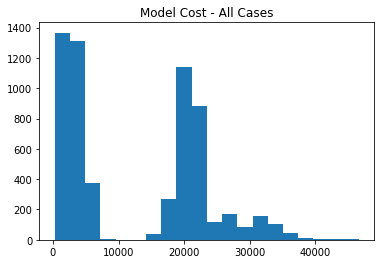

In [67]:
#Histogram of model_cost - all

fig = plt.figure()
axes1 = fig.add_subplot(1, 1, 1)
axes1.hist(df_NoOutlier['model_cost'], bins=20)
axes1.set_title('Model Cost - All Cases')
fig.show()

Look at the number of data points and means before/after for the entire dataset. (df_before_all is the before upgrade subset of df_NoOutlier. df_after_all is the after subset of df_NoOutlier):

In [68]:
df_before_all.shape

(4784, 102)

In [69]:
df_after_all.shape

(1301, 102)

In [70]:
#Model_cost stats for all before cases
df_before_all.model_cost.describe()

count     4784.000000
mean     13206.981917
std      10599.138865
min        259.520000
25%       2744.645000
50%       6720.330000
75%      21285.402500
max      46640.970000
Name: model_cost, dtype: float64

In [71]:
#Model_cost stats for all after cases
df_after_all.model_cost.describe()

count     1301.000000
mean     11734.926318
std       9076.027339
min        398.450000
25%       2937.870000
50%       6562.030000
75%      20886.670000
max      38997.560000
Name: model_cost, dtype: float64

Text(0.5, 1.0, 'Distribution of Mean Model Cost, Before and After Upgrade, All Cases')

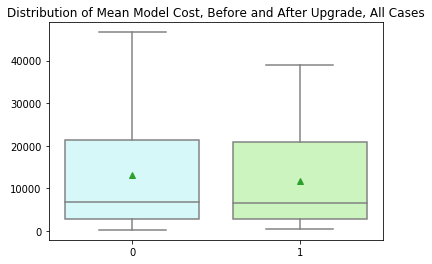

In [72]:
#Before is shown in blue, after in green
sns.boxplot(
    data=[df_before_all.model_cost, df_after_all.model_cost],
    palette=[sns.xkcd_rgb["pale blue"], sns.xkcd_rgb["pale green"]],
    showmeans=True)

plt.title('Distribution of Mean Model Cost, Before and After Upgrade, All Cases')

This is pretty, but doesn't tell us a whole lot. The overall mean is lower after the upgrade, but perhaps less complex runs ran more frequently afer the upgrade. To dig deeper, we can normalize the data or analyze by case. 

## Normalization of Span Cases

Normalize the model_cost data for cases spanning the upgrade by dividng each model_cost by the average model cost for that case. First, look and see if pre-normalized data is normal for the span cases:

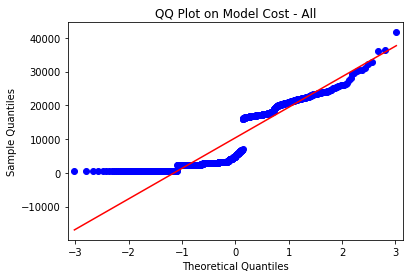

In [73]:
sm.qqplot(df_CaseSpan.model_cost, line='s')
plt.title('QQ Plot on Model Cost - All')
pylab.show()

QQ plot shows that this data is not normal.

In [74]:
#Normalize the data

# 1. Create a df grouping by case and take the mean (Case_Mean_Cost), then merge onto df_CaseSpan by case
df_CaseMean = df_CaseSpan.groupby(['case'])['model_cost'].mean().reset_index(name = "Case_Mean_Cost")
#Append df_CaseSpan with mean cost per case
df_CaseSpan = pd.merge(df_CaseSpan, df_CaseMean, on=['case'], how = 'inner') 

# 2. Divide each model_cost by the mean for its case in a column called Norm_Model_Cost
df_CaseSpan['Norm_Model_Cost'] = df_CaseSpan.model_cost / df_CaseSpan.Case_Mean_Cost

#3. Create before and after dfs
df_before_cases = df_CaseSpan[df_CaseSpan.Before_After == '1']
df_after_cases = df_CaseSpan[df_CaseSpan.Before_After == '2']

Text(0, 0.5, 'Density')

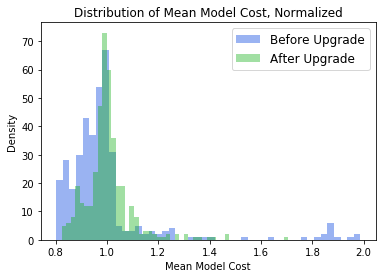

In [75]:
#Plot the before/after distributions of the normalized case data:

sns.distplot(df_before_cases.Norm_Model_Cost,  kde=False, label='Before Upgrade', color=sns.xkcd_rgb["blue"])
sns.distplot(df_after_cases.Norm_Model_Cost,  kde=False,label='After Upgrade', color=sns.xkcd_rgb["green"])

# Plot formatting
plt.legend(prop={'size': 12})
plt.title('Distribution of Mean Model Cost, Normalized')
plt.xlabel('Mean Model Cost')
plt.ylabel('Density')

In [76]:
#import plotly.express as px
    
#Have to put dates in order for some reason
df_DateSort = df_CaseSpan.sort_values(by='curr_date')
#Plot
fig = px.line(df_DateSort, x = 'curr_date', y = 'Norm_Model_Cost', title= 'Normalized Model Cost Over Time')
fig.show()

In [77]:
#Calcualte before and After means for normalized data
df_before_cases.Norm_Model_Cost.mean()

0.995367314193075

In [78]:
df_before_cases.Norm_Model_Cost.nunique()

379

In [79]:
df_after_cases.Norm_Model_Cost.mean()

1.004378523493328

In [80]:
df_after_cases.Norm_Model_Cost.nunique()

401

Text(0.5, 1.0, 'Distribution of Mean Model Cost, Normalized, for Span Cases')

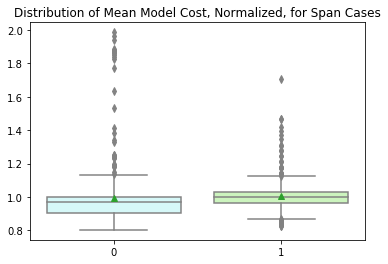

In [81]:
#Before is shown in blue, after in green
sns.boxplot(
    data=[df_before_cases.Norm_Model_Cost, df_after_cases.Norm_Model_Cost],
    palette=[sns.xkcd_rgb["pale blue"], sns.xkcd_rgb["pale green"]],
    showmeans=True)

plt.title('Distribution of Mean Model Cost, Normalized, for Span Cases')

We see that for similar numbers of data points before and after the upgrade, the mean model cost is slightly higher after the upgrade.

## Normality Testing - Normalized Cases

Test the normalized before and after data for normal distribution. This will determine which kinds of statistical testing to pursue.

In [82]:
#KS test for normality - Normalized Before Cases
scipy.stats.kstest(df_before_cases.Norm_Model_Cost, "norm")

KstestResult(statistic=0.7887360875971079, pvalue=8.305612702916235e-252)

In [83]:
#KS test for normality - Normalized After Cases
scipy.stats.kstest(df_after_cases.Norm_Model_Cost, "norm")

KstestResult(statistic=0.794844120916955, pvalue=5.7454169864742597e-272)

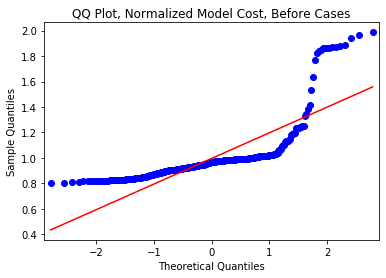

In [84]:
#QQ Plot on Normalized Before Cases
sm.qqplot(df_before_cases.Norm_Model_Cost, line='s')
plt.title('QQ Plot, Normalized Model Cost, Before Cases')
pylab.show()

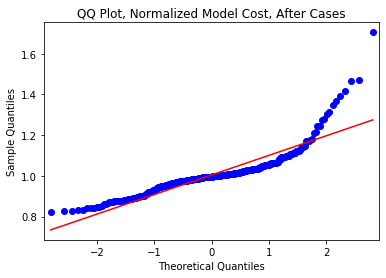

In [85]:
#QQ Plot on Normalized After Cases
sm.qqplot(df_after_cases.Norm_Model_Cost, line='s')
plt.title('QQ Plot, Normalized Model Cost, After Cases')
pylab.show()

With tiny p-values far below 0.05 and qqplots that don't fall close to a straight line, we can say that this data is not normal. 

## Significance Testing - Normalized Cases

We can't do a t-test of other parametric tests on this non-normal data, but we can do non-parametric testing to see if there is a statistically significant difference between the normalized model cost of the groups.

In [86]:
#Kruskal Wallis

#'The Kruskal-Wallis H test (sometimes also called the "one-way ANOVA on ranks") is a rank-based nonparametric test 
#that can be used to determine if there are statistically significant differences between two or more groups 
#of an independent variable on a continuous or ordinal dependent variable.'
#https://statistics.laerd.com/spss-tutorials/kruskal-wallis-h-test-using-spss-statistics.php
scipy.stats.kruskal(df_before_cases.Norm_Model_Cost, df_after_cases.Norm_Model_Cost)

KruskalResult(statistic=53.43717152478439, pvalue=2.6699671386248273e-13)

In [87]:
#Mann Whitney U

#'The Mann-Whitney U test is used to compare differences between two independent groups when the dependent 
#variable is either ordinal or continuous, but not normally distributed.'
#https://statistics.laerd.com/spss-tutorials/mann-whitney-u-test-using-spss-statistics.php
scipy.stats.mannwhitneyu(df_before_cases.Norm_Model_Cost, df_after_cases.Norm_Model_Cost, alternative='two-sided')

MannwhitneyuResult(statistic=52999.0, pvalue=2.673127970539464e-13)

In [88]:
#Paired Wilcoxon Signed Rank Test

#The Wilcoxon signed-rank test tests the null hypothesis that two related paired samples come from the same distribution. 
#In particular, it tests whether the distribution of the differences x - y is symmetric about zero. 
#It is a non-parametric version of the paired T-test.

#But the samples must have the same length

#scipy.stats.wilcoxon(before_all.model_cost, after_all.model_cost)

Because the p-values are less than 0.05, we reject the null hypothesis that there's no difference between the means and conclude that a significant difference does exist!

## Examination of Normality and H0 by Case

Now, we can look at whether the data is normal for any particular span case, and also whether the distributions are normal when comparing before and after data by case. For simplicity, we'll assign ordinal case numbers for reference and plotting:

In [89]:
#Give case names new IDs 1-14
df_CaseSpan['CaseNum'] = pd.factorize(df_CaseSpan.case)[0] + 1
df_CaseSpan.CaseNum.nunique()

14

In [90]:
#Write a dataframe to a csv file
#df_CaseSpan.to_csv('df_CaseSpan.csv', sep=',')

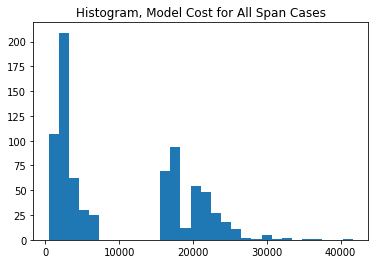

In [91]:
#Histogram, Model Cost for All Span Cases
fig = plt.figure()
axes1 = fig.add_subplot(1, 1, 1)
axes1.hist(df_CaseSpan['model_cost'], bins=30)
axes1.set_title('Histogram, Model Cost for All Span Cases')
fig.show()

In [92]:
#Subset individual cases
#OK I'm sure there is a better way to do this, but, sometimes the fastest way is the way you know how . . .
Case1 = df_CaseSpan[df_CaseSpan.CaseNum == 1]
Case2 = df_CaseSpan[df_CaseSpan.CaseNum == 2]
Case3 = df_CaseSpan[df_CaseSpan.CaseNum == 3]
Case4 = df_CaseSpan[df_CaseSpan.CaseNum == 4]
Case5 = df_CaseSpan[df_CaseSpan.CaseNum == 5]
Case6 = df_CaseSpan[df_CaseSpan.CaseNum == 6]
Case7 = df_CaseSpan[df_CaseSpan.CaseNum == 7]
Case8 = df_CaseSpan[df_CaseSpan.CaseNum == 8]
Case9 = df_CaseSpan[df_CaseSpan.CaseNum == 9]
Case10 = df_CaseSpan[df_CaseSpan.CaseNum == 10]
Case11 = df_CaseSpan[df_CaseSpan.CaseNum == 11]
Case12 = df_CaseSpan[df_CaseSpan.CaseNum == 12]
Case13 = df_CaseSpan[df_CaseSpan.CaseNum == 13]
Case14 = df_CaseSpan[df_CaseSpan.CaseNum == 14]

Let's look at some qq plots to check the normality of distributions for each case:

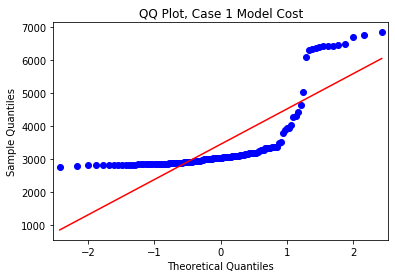

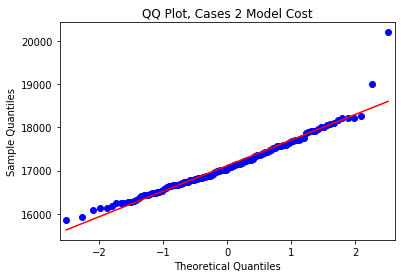

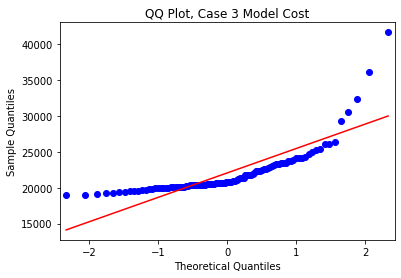

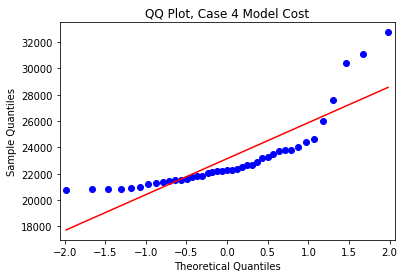

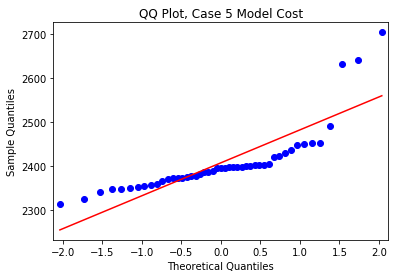

In [93]:
#I'm also sure there has to be a FacetGrid or something I can do for these, but . . . 
sm.qqplot(Case1.model_cost, line='s')
plt.title('QQ Plot, Case 1 Model Cost')
sm.qqplot(Case2.model_cost, line='s')
plt.title('QQ Plot, Cases 2 Model Cost')
sm.qqplot(Case3.model_cost, line='s')
plt.title('QQ Plot, Case 3 Model Cost')
sm.qqplot(Case4.model_cost, line='s')
plt.title('QQ Plot, Case 4 Model Cost')
sm.qqplot(Case5.model_cost, line='s')
plt.title('QQ Plot, Case 5 Model Cost')
pylab.show()

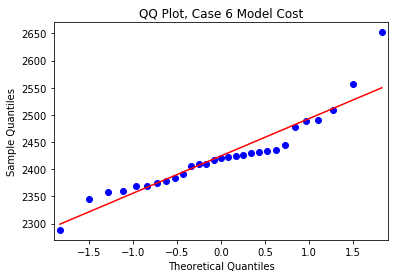

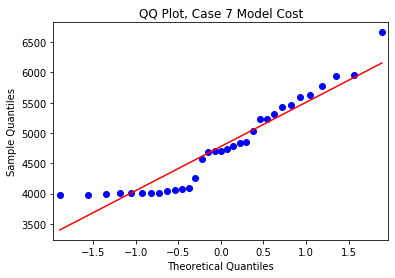

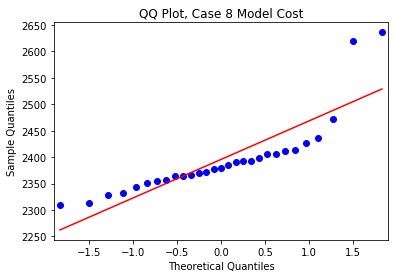

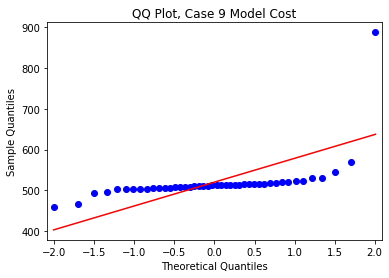

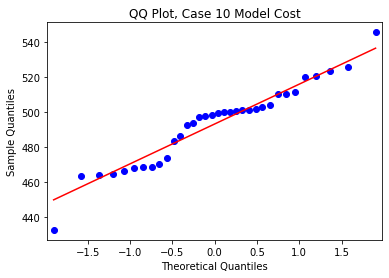

In [94]:
sm.qqplot(Case6.model_cost, line='s')
plt.title('QQ Plot, Case 6 Model Cost')
sm.qqplot(Case7.model_cost, line='s')
plt.title('QQ Plot, Case 7 Model Cost')
sm.qqplot(Case8.model_cost, line='s')
plt.title('QQ Plot, Case 8 Model Cost')
sm.qqplot(Case9.model_cost, line='s')
plt.title('QQ Plot, Case 9 Model Cost')
sm.qqplot(Case10.model_cost, line='s')
plt.title('QQ Plot, Case 10 Model Cost')
pylab.show()

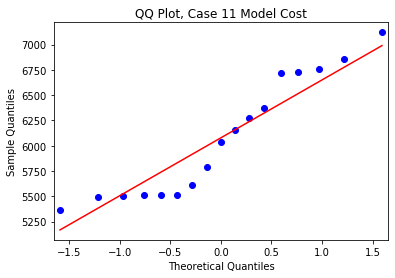

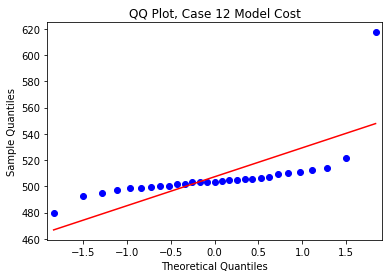

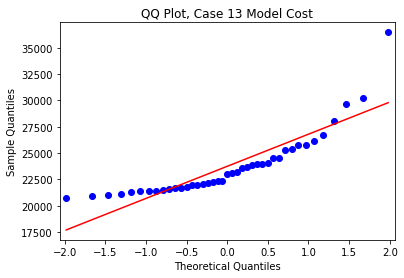

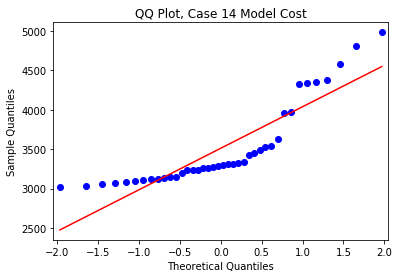

In [95]:
sm.qqplot(Case11.model_cost, line='s')
plt.title('QQ Plot, Case 11 Model Cost')
sm.qqplot(Case12.model_cost, line='s')
plt.title('QQ Plot, Case 12 Model Cost')
sm.qqplot(Case13.model_cost, line='s')
plt.title('QQ Plot, Case 13 Model Cost')
sm.qqplot(Case14.model_cost, line='s')
plt.title('QQ Plot, Case 14 Model Cost')
pylab.show()

So all of these would fail the tests for normality, with the possible exception of Case2, so let's look at that closer:

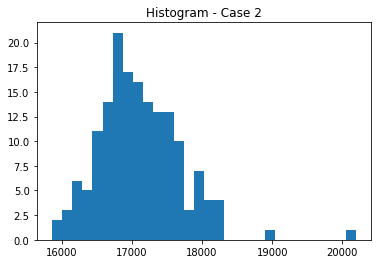

In [96]:
#Histogram Case 2
fig = plt.figure()
axes1 = fig.add_subplot(1, 1, 1)
axes1.hist(Case2['model_cost'], bins=30)
axes1.set_title('Histogram - Case 2')
fig.show()

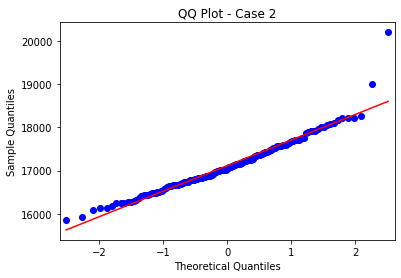

In [97]:
sm.qqplot(Case2.model_cost, line='s')
plt.title('QQ Plot - Case 2')
pylab.show()

In [98]:
from scipy.stats import shapiro
stat, p = shapiro(Case2.model_cost)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')
    
#https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/

Statistics=0.949, p=0.000
Sample does not look Gaussian (reject H0)


The overall data for Case2 fails the test for normality. Are the before and after groups at least normal for Case 2?

In [99]:
Case2_before = Case2[Case2.Before_After == '1']

from scipy.stats import shapiro
stat, p = shapiro(Case2_before.model_cost)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.818, p=0.000
Sample does not look Gaussian (reject H0)


In [100]:
Case2_after = Case2[Case2.Before_After == '2']

from scipy.stats import shapiro
stat, p = shapiro(Case2_after.model_cost)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.978, p=0.048
Sample does not look Gaussian (reject H0)


None of the data is normal for Case2!

## Statistical Significance Testing

Let's run through each case and find out whether there is a statistically significant difference between before/after model cost:

In [101]:
#Kruskal Wallis on Case 1
Case1_before = Case1[Case1.Before_After == '1']
Case1_after = Case1[Case1.Before_After == '2']
scipy.stats.kruskal(Case1_before.model_cost, Case1_after.model_cost)

KruskalResult(statistic=10.848676909944459, pvalue=0.000988663715158928)

In [102]:
KW = scipy.stats.kruskal(Case1_before.model_cost, Case1_after.model_cost)
kw =str(KW)
p = kw.rpartition('=')[-1]
p = p.strip(')') 
p = float(p)
p

0.000988663715158928

In [103]:
#Loop through and find KW for each case:
nums = df_CaseSpan.CaseNum.unique()
df = []

for i in nums:
    df = df_CaseSpan[df_CaseSpan.CaseNum == i]  #Set CaseNum to i, take subset
    df_bef = df[df.Before_After == '1']         #Get Before df
    df_aft = df[df.Before_After == '2']         #Get After df
    KW = scipy.stats.kruskal(df_bef.model_cost, df_aft.model_cost)   #Get Kruskal Wallis output string
     
    kw =str(KW)                       #Convert KW to a string
    p = kw.rpartition('=')[-1]        #Partition KW string at right-most '='
    p = p.strip(')')                  #Strip trailing right parenthesis
    p = float(p)                      #Convert to float. Now we have a numeric p-value
    
    significant = p <= 0.05           #Boolean comparison for significance
    print ('CaseNum: ', i , KW, significant)

CaseNum:  1 KruskalResult(statistic=10.848676909944459, pvalue=0.000988663715158928) True
CaseNum:  2 KruskalResult(statistic=1.0353434197147067, pvalue=0.3089069478055688) False
CaseNum:  3 KruskalResult(statistic=20.279301106581272, pvalue=6.692066335454196e-06) True
CaseNum:  4 KruskalResult(statistic=4.533751962323379, pvalue=0.03323268116809464) True
CaseNum:  5 KruskalResult(statistic=3.815020161290306, pvalue=0.05079499384231141) False
CaseNum:  6 KruskalResult(statistic=3.750649350649354, pvalue=0.052787000632224676) False
CaseNum:  7 KruskalResult(statistic=20.537104072398193, pvalue=5.8486481463722745e-06) True
CaseNum:  8 KruskalResult(statistic=4.807692307692307, pvalue=0.028332962784810296) True
CaseNum:  9 KruskalResult(statistic=11.468554829339155, pvalue=0.0007078370295733665) True
CaseNum:  10 KruskalResult(statistic=2.5652001977261563, pvalue=0.10923872782341319) False
CaseNum:  11 KruskalResult(statistic=7.36363636363636, pvalue=0.006655605482949406) True
CaseNum:  1

The above analysis shows that the differences in model cost per case are significant for all cases but 2, 5, 6, and 10. Therefore, in 10/14 of the cases (about 70%), the difference was statistically significant. Was it better or worse? We'll look at that next. (Above, True = statistically significant).

## Upgrade Plots - Percent Change

Here I'll take just a few columns to make things easier to think about and look at, and calculate the percent change in before and after performance by case (Case_Mean_Cost_BA).

In [104]:
#Create a df grouping by case, calculate mean before/after
df_before_after = df_CaseSpan.groupby(['case', 'Before_After'])['model_cost'].mean().reset_index(name = "Case_Mean_Cost_BA")
#Append df_CaseSpan with Before_After column
df_CaseSpan = pd.merge(df_CaseSpan, df_before_after, on=['case', 'Before_After'], how = 'inner')  

In [105]:
#Subset by before/after and case
df_CaseSet = df_CaseSpan[['CaseNum', 'comp_pes_atm', 'compset', 'Before_After', 'Case_Mean_Cost_BA']]
df_CaseSet.drop_duplicates(subset=None, keep="first", inplace=True)
with pd.option_context('max.rows', 1000):
    display(df_CaseSet)

CaseNum  comp_pes_atm                                            compset  \
0          1          1800  1850_CAM60_CLM50%BGC-CROP_CICE_POP2%ECO_MOSART...   
71         1          1800  1850_CAM60_CLM50%BGC-CROP_CICE_POP2%ECO_MOSART...   
131        2          1728  HIST_CAM60%WCTS%AERCHEM-piCH4_CLM50%BGC-CROP_C...   
177        2          1728  HIST_CAM60%WCTS%AERCHEM-piCH4_CLM50%BGC-CROP_C...   
296        3          3456  1850_CAM60%WCTS%4xCO2_CLM50%BGC-CROP-CMIP6WACC...   
381        3          3456  1850_CAM60%WCTS%4xCO2_CLM50%BGC-CROP-CMIP6WACC...   
396        4          3456  SSP370_CAM60%WCTS_CLM50%BGC-CROP-CMIP6WACCMDEC...   
424        4          3456  SSP370_CAM60%WCTS_CLM50%BGC-CROP-CMIP6WACCMDEC...   
437        5          1728  1850_CAM60_CLM50%BGC-CROP_CICE%PRES_DOCN%DOM_M...   
468        5          1728  1850_CAM60_CLM50%BGC-CROP_CICE%PRES_DOCN%DOM_M...   
484        6          1728  HIST_CAM60_CLM50%BGC-CROP_CICE%PRES_DOCN%DOM_M...   
491        6          1728  HIST_CAM60_CLM50%BGC-CROP_CICE%PRES_DOCN%DOM_M...   
513        7          3456  1850_CAM60_CLM50%BGC-CROP-CMIP6DECK_CICE%CMIP6...   
526        7          3456  1850_CAM60_CLM50%BGC-CROP-CMIP6DECK_CICE%CMIP6...   
546        8          1728  HIST_CAM60_CLM50%BGC-CROP_CICE%PRES_DOCN%DOM_M...   
559        8          1728  HIST_CAM60_CLM50%BGC-CROP_CICE%PRES_DOCN%DOM_M...   
575        9            72  OMIP_DATM%JRA_SLND_CICE_POP2%ECO_DROF%JRA_SGLC...   
602        9            72  OMIP_DATM%JRA_SLND_CICE_POP2%ECO_DROF%JRA_SGLC...   
619       10            72  OMIP_DATM%IAF_SLND_CICE_POP2%ECO_DROF%IAF_SGLC...   
636       10            72  OMIP_DATM%IAF_SLND_CICE_POP2%ECO_DROF%IAF_SGLC...   
653       11          3456  SSP585_CAM60_CLM50%BGC-CROP-CMIP6DECK_CICE%CMI...   
659       11          3456  SSP585_CAM60_CLM50%BGC-CROP-CMIP6DECK_CICE%CMI...   
670       12            72  OMIP_DATM%IAF_SLND_CICE_POP2%ECO_DROF%IAF_SGLC...   
682       12            72  OMIP_DATM%IAF_SLND_CICE_POP2%ECO_DROF%IAF_SGLC...   
699       13          3456  SSP370_CAM60%WCTS_CLM50%BGC-CROP-CMIP6WACCMDEC...   
711       13          3456  SSP370_CAM60%WCTS_CLM50%BGC-CROP-CMIP6WACCMDEC...   
740       14          1800  1850_CAM60%1PCT_CLM50%BGC-CROP_CICE%CMIP6_POP2...   
774       14          1800  1850_CAM60%1PCT_CLM50%BGC-CROP_CICE%CMIP6_POP2...   

    Before_After  Case_Mean_Cost_BA  
0              1        3622.138028  
71             2        3225.723667  
131            1       17052.681957  
177            2       17139.674958  
296            1       21681.152941  
381            2       24217.121333  
396            1       22823.561429  
424            2       23848.116923  
437            2        2419.848065  
468            1        2382.045000  
484            1        2391.220000  
491            2        2435.216818  
513            1        4087.313846  
526            2        5226.652000  
546            2        2412.976154  
559            1        2381.630000  
575            1         506.373704  
602            2         542.335882  
619            2         497.904118  
636            1         488.412941  
653            1        5525.816667  
659            2        6380.260000  
670            1         498.825833  
682            2         513.254706  
699            2       25368.186667  
711            1       23076.628276  
740            2        3387.858235  
774            1        4220.516667

In [106]:
df_CaseDiff_Before = df_CaseSet[df_CaseSet.Before_After =='1']
df_CaseDiff_Before

CaseNum  comp_pes_atm                                            compset  \
0          1          1800  1850_CAM60_CLM50%BGC-CROP_CICE_POP2%ECO_MOSART...   
131        2          1728  HIST_CAM60%WCTS%AERCHEM-piCH4_CLM50%BGC-CROP_C...   
296        3          3456  1850_CAM60%WCTS%4xCO2_CLM50%BGC-CROP-CMIP6WACC...   
396        4          3456  SSP370_CAM60%WCTS_CLM50%BGC-CROP-CMIP6WACCMDEC...   
468        5          1728  1850_CAM60_CLM50%BGC-CROP_CICE%PRES_DOCN%DOM_M...   
484        6          1728  HIST_CAM60_CLM50%BGC-CROP_CICE%PRES_DOCN%DOM_M...   
513        7          3456  1850_CAM60_CLM50%BGC-CROP-CMIP6DECK_CICE%CMIP6...   
559        8          1728  HIST_CAM60_CLM50%BGC-CROP_CICE%PRES_DOCN%DOM_M...   
575        9            72  OMIP_DATM%JRA_SLND_CICE_POP2%ECO_DROF%JRA_SGLC...   
636       10            72  OMIP_DATM%IAF_SLND_CICE_POP2%ECO_DROF%IAF_SGLC...   
653       11          3456  SSP585_CAM60_CLM50%BGC-CROP-CMIP6DECK_CICE%CMI...   
670       12            72  OMIP_DATM%IAF_SLND_CICE_POP2%ECO_DROF%IAF_SGLC...   
711       13          3456  SSP370_CAM60%WCTS_CLM50%BGC-CROP-CMIP6WACCMDEC...   
774       14          1800  1850_CAM60%1PCT_CLM50%BGC-CROP_CICE%CMIP6_POP2...   

    Before_After  Case_Mean_Cost_BA  
0              1        3622.138028  
131            1       17052.681957  
296            1       21681.152941  
396            1       22823.561429  
468            1        2382.045000  
484            1        2391.220000  
513            1        4087.313846  
559            1        2381.630000  
575            1         506.373704  
636            1         488.412941  
653            1        5525.816667  
670            1         498.825833  
711            1       23076.628276  
774            1        4220.516667

In [107]:
df_CaseDiff_After = df_CaseSet[df_CaseSet.Before_After == '2']
df_CaseDiff_After

CaseNum  comp_pes_atm                                            compset  \
71         1          1800  1850_CAM60_CLM50%BGC-CROP_CICE_POP2%ECO_MOSART...   
177        2          1728  HIST_CAM60%WCTS%AERCHEM-piCH4_CLM50%BGC-CROP_C...   
381        3          3456  1850_CAM60%WCTS%4xCO2_CLM50%BGC-CROP-CMIP6WACC...   
424        4          3456  SSP370_CAM60%WCTS_CLM50%BGC-CROP-CMIP6WACCMDEC...   
437        5          1728  1850_CAM60_CLM50%BGC-CROP_CICE%PRES_DOCN%DOM_M...   
491        6          1728  HIST_CAM60_CLM50%BGC-CROP_CICE%PRES_DOCN%DOM_M...   
526        7          3456  1850_CAM60_CLM50%BGC-CROP-CMIP6DECK_CICE%CMIP6...   
546        8          1728  HIST_CAM60_CLM50%BGC-CROP_CICE%PRES_DOCN%DOM_M...   
602        9            72  OMIP_DATM%JRA_SLND_CICE_POP2%ECO_DROF%JRA_SGLC...   
619       10            72  OMIP_DATM%IAF_SLND_CICE_POP2%ECO_DROF%IAF_SGLC...   
659       11          3456  SSP585_CAM60_CLM50%BGC-CROP-CMIP6DECK_CICE%CMI...   
682       12            72  OMIP_DATM%IAF_SLND_CICE_POP2%ECO_DROF%IAF_SGLC...   
699       13          3456  SSP370_CAM60%WCTS_CLM50%BGC-CROP-CMIP6WACCMDEC...   
740       14          1800  1850_CAM60%1PCT_CLM50%BGC-CROP_CICE%CMIP6_POP2...   

    Before_After  Case_Mean_Cost_BA  
71             2        3225.723667  
177            2       17139.674958  
381            2       24217.121333  
424            2       23848.116923  
437            2        2419.848065  
491            2        2435.216818  
526            2        5226.652000  
546            2        2412.976154  
602            2         542.335882  
619            2         497.904118  
659            2        6380.260000  
682            2         513.254706  
699            2       25368.186667  
740            2        3387.858235

In [108]:
#Calculate Percent Change per case
diff_list = []
for i in df_CaseDiff_Before.CaseNum:        #Iterates through each case 
    x = df_CaseDiff_Before.Case_Mean_Cost_BA[df_CaseDiff_Before.CaseNum == i].item()  #Takes the before mean cost
    y = df_CaseDiff_After.Case_Mean_Cost_BA[df_CaseDiff_After.CaseNum == i].item()    #Takes the after mean cost
    diff = (y-x)/x*100                      #Calculates the percent change
    diff_list.append(diff)                  #Creates a list of percent changes

#Create a df with CaseNum and its percent change in mean cost before/after
df_diff_list = pd.DataFrame(data = diff_list , columns=['MeanPercDiff']).reset_index()  
df_diff_list.columns = ['CaseNum', 'MeanPercDiff']
df_diff_list['CaseNum'] = df_diff_list.CaseNum + 1
df_diff_list

CaseNum  MeanPercDiff
0         1    -10.944209
1         2      0.510143
2         3     11.696649
3         4      4.489026
4         5      1.587000
5         6      1.839932
6         7     27.874986
7         8      1.316164
8         9      7.101905
9        10      1.943269
10       11     15.462752
11       12      2.892567
12       13      9.930213
13       14    -19.728827

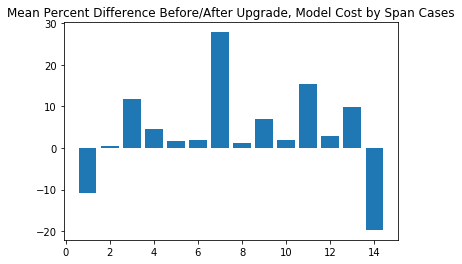

In [109]:
#Plot percent change per case 
#Create bars
plt.bar(df_diff_list.CaseNum, df_diff_list.MeanPercDiff)
 
# Show graphic
plt.title('Mean Percent Difference Before/After Upgrade, Model Cost by Span Cases')
plt.show()

Remember from above, the statistical testing showed that the differences in before/after model cost for cases 2, 5, 6, and 10 were not statistically significant. Indeed, they show a small percent change. We might look closer at case 8, which also had a small percent change however, the change was significant. For cases 1 and 14, the change was for the better. For the others, it was worse.

In [110]:
#Append df_CaseDiff_Before with MeanPercDiff
df_diff_new = pd.merge(df_CaseDiff_Before, df_diff_list, on=['CaseNum'], how = 'inner')
del df_diff_new['Before_After']
del df_diff_new['Case_Mean_Cost_BA']
df_diff_new

CaseNum  comp_pes_atm                                            compset  \
0         1          1800  1850_CAM60_CLM50%BGC-CROP_CICE_POP2%ECO_MOSART...   
1         2          1728  HIST_CAM60%WCTS%AERCHEM-piCH4_CLM50%BGC-CROP_C...   
2         3          3456  1850_CAM60%WCTS%4xCO2_CLM50%BGC-CROP-CMIP6WACC...   
3         4          3456  SSP370_CAM60%WCTS_CLM50%BGC-CROP-CMIP6WACCMDEC...   
4         5          1728  1850_CAM60_CLM50%BGC-CROP_CICE%PRES_DOCN%DOM_M...   
5         6          1728  HIST_CAM60_CLM50%BGC-CROP_CICE%PRES_DOCN%DOM_M...   
6         7          3456  1850_CAM60_CLM50%BGC-CROP-CMIP6DECK_CICE%CMIP6...   
7         8          1728  HIST_CAM60_CLM50%BGC-CROP_CICE%PRES_DOCN%DOM_M...   
8         9            72  OMIP_DATM%JRA_SLND_CICE_POP2%ECO_DROF%JRA_SGLC...   
9        10            72  OMIP_DATM%IAF_SLND_CICE_POP2%ECO_DROF%IAF_SGLC...   
10       11          3456  SSP585_CAM60_CLM50%BGC-CROP-CMIP6DECK_CICE%CMI...   
11       12            72  OMIP_DATM%IAF_SLND_CICE_POP2%ECO_DROF%IAF_SGLC...   
12       13          3456  SSP370_CAM60%WCTS_CLM50%BGC-CROP-CMIP6WACCMDEC...   
13       14          1800  1850_CAM60%1PCT_CLM50%BGC-CROP_CICE%CMIP6_POP2...   

    MeanPercDiff  
0     -10.944209  
1       0.510143  
2      11.696649  
3       4.489026  
4       1.587000  
5       1.839932  
6      27.874986  
7       1.316164  
8       7.101905  
9       1.943269  
10     15.462752  
11      2.892567  
12      9.930213  
13    -19.728827

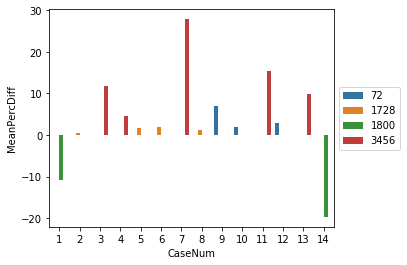

In [111]:
#Plot and show number of atmospheric processors:

fig, ax1 = plt.subplots(1,1)
g = sns.barplot(x="CaseNum", y="MeanPercDiff", hue="comp_pes_atm", ax=ax1, data=df_diff_new)
box = g.get_position()
g.set_position([box.x0, box.y0, box.width * 0.85, box.height]) # resize position

# Put a legend to the right side
g.legend(loc='center right', bbox_to_anchor=(1.25, 0.5), ncol=1)

plt.show()

Yes, I would like these bars to be wider.

Well, that is a pretty sucky graph. Let's try again with plotly express:

In [112]:
import plotly.express as px
df_diff_new['comp_pes_atm'] = df_diff_new['comp_pes_atm'].apply(str)
fig = px.bar(df_diff_new, x = 'CaseNum', y = 'MeanPercDiff', color = 'comp_pes_atm',\
             title='Mean Percent Difference (Before/After Upgrade) of Model Cost by Span Cases')
fig.update_xaxes(tickvals=[1,2,3,4,5,6,7,8,9,10,11,12,13,14])
fig.show()

Which cases are the ones that improved, the ones with 1800 processors?

In [113]:
subset1 = df_CaseSpan[df_CaseSpan.CaseNum ==1]
print("Case 1 name: " , subset1.case.unique())
print("Case 1 compset:", subset1.compset.unique())
print("Case 1 comp_pes_atm", subset1.comp_pes_atm.unique())

Case 1 name:  ['b.e21.B1850G.f09_g17_gl4.CMIP6-piControl-withism.001']
Case 1 compset: ['1850_CAM60_CLM50%BGC-CROP_CICE_POP2%ECO_MOSART_CISM2%EVOLVE_WW3_BGC%BDRD']
Case 1 comp_pes_atm [1800]


In [114]:
subset14 = df_CaseSpan[df_CaseSpan.CaseNum ==14]
print("Case 14 name: " , subset14.case.unique())
print("Case 14 compset:", subset14.compset.unique())
print("Case 14 comp_pes_atm", subset14.comp_pes_atm.unique())

Case 14 name:  ['b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001']
Case 14 compset: ['1850_CAM60%1PCT_CLM50%BGC-CROP_CICE%CMIP6_POP2%ECO_MOSART_CISM2%EVOLVE_WW3_BGC%BDRD']
Case 14 comp_pes_atm [1800]


Look at model_cost variation within cases:

In [115]:
fig = px.box(df_CaseSpan, x="CaseNum", y="model_cost", color='comp_pes_atm', \
            title = 'Model Cost Variation by Span Case')
fig.update_xaxes(tickvals=[1,2,3,4,5,6,7,8,9,10,11,12,13,14])
fig.show()

# Means by Week

Look at model cost means grouped by week. 

In [116]:
#Create a df grouping by case, Week, and calculate mean_by_week
df_weeks = df_CaseSpan.groupby(['case', 'Week'])['model_cost'].mean().reset_index(name = "Case_Mean_Cost_Week")
#Append df_CaseSpan with mean_by_week
df_CaseSpan = pd.merge(df_CaseSpan, df_weeks, on=['case', 'Week'], how = 'inner')               

In [117]:
#Subset by weekly mean values (drop duplicates)
#Simplify dataset by taking just a few columns:
#Just take the columns we want to duplicate through the WeekSet
df_WeekSet = df_CaseSpan[['CaseNum', 'comp_pes_atm', 'compset', 'grid', 'Week', 'Before_After', 'Case_Mean_Cost_Week']]
df_WeekSet.drop_duplicates(subset=None, keep="first", inplace=True)
df_WeekSet

CaseNum  comp_pes_atm                                            compset  \
0          1          1800  1850_CAM60_CLM50%BGC-CROP_CICE_POP2%ECO_MOSART...   
24         1          1800  1850_CAM60_CLM50%BGC-CROP_CICE_POP2%ECO_MOSART...   
39         1          1800  1850_CAM60_CLM50%BGC-CROP_CICE_POP2%ECO_MOSART...   
48         1          1800  1850_CAM60_CLM50%BGC-CROP_CICE_POP2%ECO_MOSART...   
54         1          1800  1850_CAM60_CLM50%BGC-CROP_CICE_POP2%ECO_MOSART...   
61         1          1800  1850_CAM60_CLM50%BGC-CROP_CICE_POP2%ECO_MOSART...   
67         1          1800  1850_CAM60_CLM50%BGC-CROP_CICE_POP2%ECO_MOSART...   
71         1          1800  1850_CAM60_CLM50%BGC-CROP_CICE_POP2%ECO_MOSART...   
85         1          1800  1850_CAM60_CLM50%BGC-CROP_CICE_POP2%ECO_MOSART...   
96         1          1800  1850_CAM60_CLM50%BGC-CROP_CICE_POP2%ECO_MOSART...   
109        1          1800  1850_CAM60_CLM50%BGC-CROP_CICE_POP2%ECO_MOSART...   
120        1          1800  1850_CAM60_CLM50%BGC-CROP_CICE_POP2%ECO_MOSART...   
131        2          1728  HIST_CAM60%WCTS%AERCHEM-piCH4_CLM50%BGC-CROP_C...   
144        2          1728  HIST_CAM60%WCTS%AERCHEM-piCH4_CLM50%BGC-CROP_C...   
155        2          1728  HIST_CAM60%WCTS%AERCHEM-piCH4_CLM50%BGC-CROP_C...   
168        2          1728  HIST_CAM60%WCTS%AERCHEM-piCH4_CLM50%BGC-CROP_C...   
177        2          1728  HIST_CAM60%WCTS%AERCHEM-piCH4_CLM50%BGC-CROP_C...   
191        2          1728  HIST_CAM60%WCTS%AERCHEM-piCH4_CLM50%BGC-CROP_C...   
208        2          1728  HIST_CAM60%WCTS%AERCHEM-piCH4_CLM50%BGC-CROP_C...   
224        2          1728  HIST_CAM60%WCTS%AERCHEM-piCH4_CLM50%BGC-CROP_C...   
237        2          1728  HIST_CAM60%WCTS%AERCHEM-piCH4_CLM50%BGC-CROP_C...   
251        2          1728  HIST_CAM60%WCTS%AERCHEM-piCH4_CLM50%BGC-CROP_C...   
266        2          1728  HIST_CAM60%WCTS%AERCHEM-piCH4_CLM50%BGC-CROP_C...   
279        2          1728  HIST_CAM60%WCTS%AERCHEM-piCH4_CLM50%BGC-CROP_C...   
281        2          1728  HIST_CAM60%WCTS%AERCHEM-piCH4_CLM50%BGC-CROP_C...   
288        2          1728  HIST_CAM60%WCTS%AERCHEM-piCH4_CLM50%BGC-CROP_C...   
292        2          1728  HIST_CAM60%WCTS%AERCHEM-piCH4_CLM50%BGC-CROP_C...   
296        3          3456  1850_CAM60%WCTS%4xCO2_CLM50%BGC-CROP-CMIP6WACC...   
318        3          3456  1850_CAM60%WCTS%4xCO2_CLM50%BGC-CROP-CMIP6WACC...   
338        3          3456  1850_CAM60%WCTS%4xCO2_CLM50%BGC-CROP-CMIP6WACC...   
..       ...           ...                                                ...   
526        7          3456  1850_CAM60_CLM50%BGC-CROP-CMIP6DECK_CICE%CMIP6...   
536        7          3456  1850_CAM60_CLM50%BGC-CROP-CMIP6DECK_CICE%CMIP6...   
546        8          1728  HIST_CAM60_CLM50%BGC-CROP_CICE%PRES_DOCN%DOM_M...   
559        8          1728  HIST_CAM60_CLM50%BGC-CROP_CICE%PRES_DOCN%DOM_M...   
575        9            72  OMIP_DATM%JRA_SLND_CICE_POP2%ECO_DROF%JRA_SGLC...   
581        9            72  OMIP_DATM%JRA_SLND_CICE_POP2%ECO_DROF%JRA_SGLC...   
593        9            72  OMIP_DATM%JRA_SLND_CICE_POP2%ECO_DROF%JRA_SGLC...   
601        9            72  OMIP_DATM%JRA_SLND_CICE_POP2%ECO_DROF%JRA_SGLC...   
602        9            72  OMIP_DATM%JRA_SLND_CICE_POP2%ECO_DROF%JRA_SGLC...   
612        9            72  OMIP_DATM%JRA_SLND_CICE_POP2%ECO_DROF%JRA_SGLC...   
619       10            72  OMIP_DATM%IAF_SLND_CICE_POP2%ECO_DROF%IAF_SGLC...   
629       10            72  OMIP_DATM%IAF_SLND_CICE_POP2%ECO_DROF%IAF_SGLC...   
636       10            72  OMIP_DATM%IAF_SLND_CICE_POP2%ECO_DROF%IAF_SGLC...   
646       10            72  OMIP_DATM%IAF_SLND_CICE_POP2%ECO_DROF%IAF_SGLC...   
653       11          3456  SSP585_CAM60_CLM50%BGC-CROP-CMIP6DECK_CICE%CMI...   
659       11          3456  SSP585_CAM60_CLM50%BGC-CROP-CMIP6DECK_CICE%CMI...   
670       12            72  OMIP_DATM%IAF_SLND_CICE_POP2%ECO_DROF%IAF_SGLC...   
679       12            72  OMIP_DAT

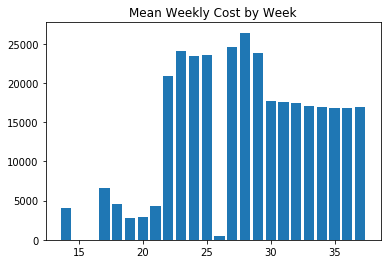

In [118]:
#Not normalized
plt.bar(df_CaseSpan.Week, df_CaseSpan.Case_Mean_Cost_Week)
plt.title('Mean Weekly Cost by Week')
# Show graphic
plt.show()

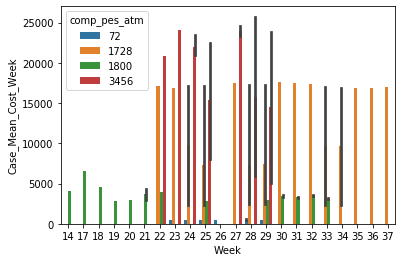

In [119]:
#?? I'm not even sure what this plot is trying to do
sns.barplot(x="Week", y="Case_Mean_Cost_Week", hue="comp_pes_atm", data=df_WeekSet)

In [120]:
#Weeks span from 14-37
df_CaseSpan.Week.describe()

count    780.000000
mean      26.861538
std        4.296616
min       14.000000
25%       24.000000
50%       27.000000
75%       29.000000
max       37.000000
Name: Week, dtype: float64

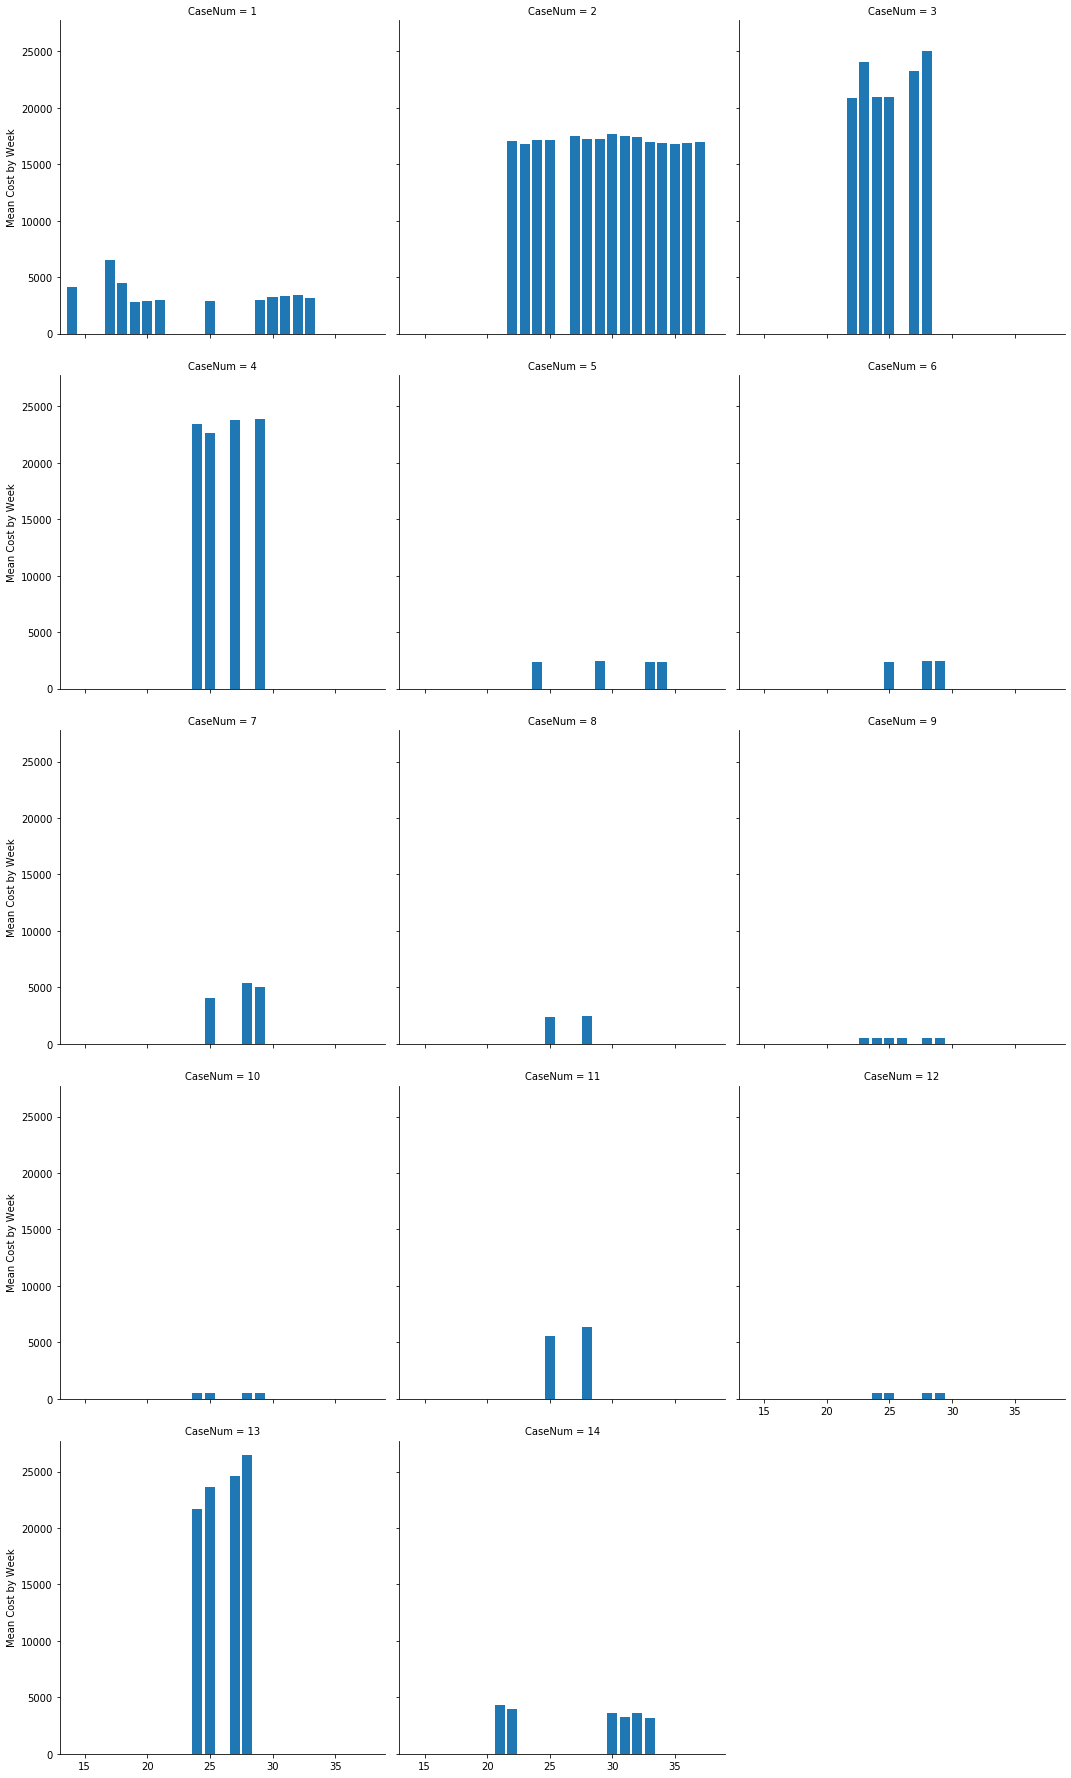

In [121]:
#Plot the mean costs for each week, by week and case
#This plot shares the y axis of model cost

g = sns.FacetGrid(df_CaseSpan, col='CaseNum', col_wrap=3, height=5)
g.map(plt.bar, "Week", "Case_Mean_Cost_Week")

g.set_xlabels('')
g.set_ylabels('Mean Cost by Week')
  
for ax in g.axes.flat:
    ax.set_xlim(13, 39)

plt.show()

No handles with labels found to put in legend.


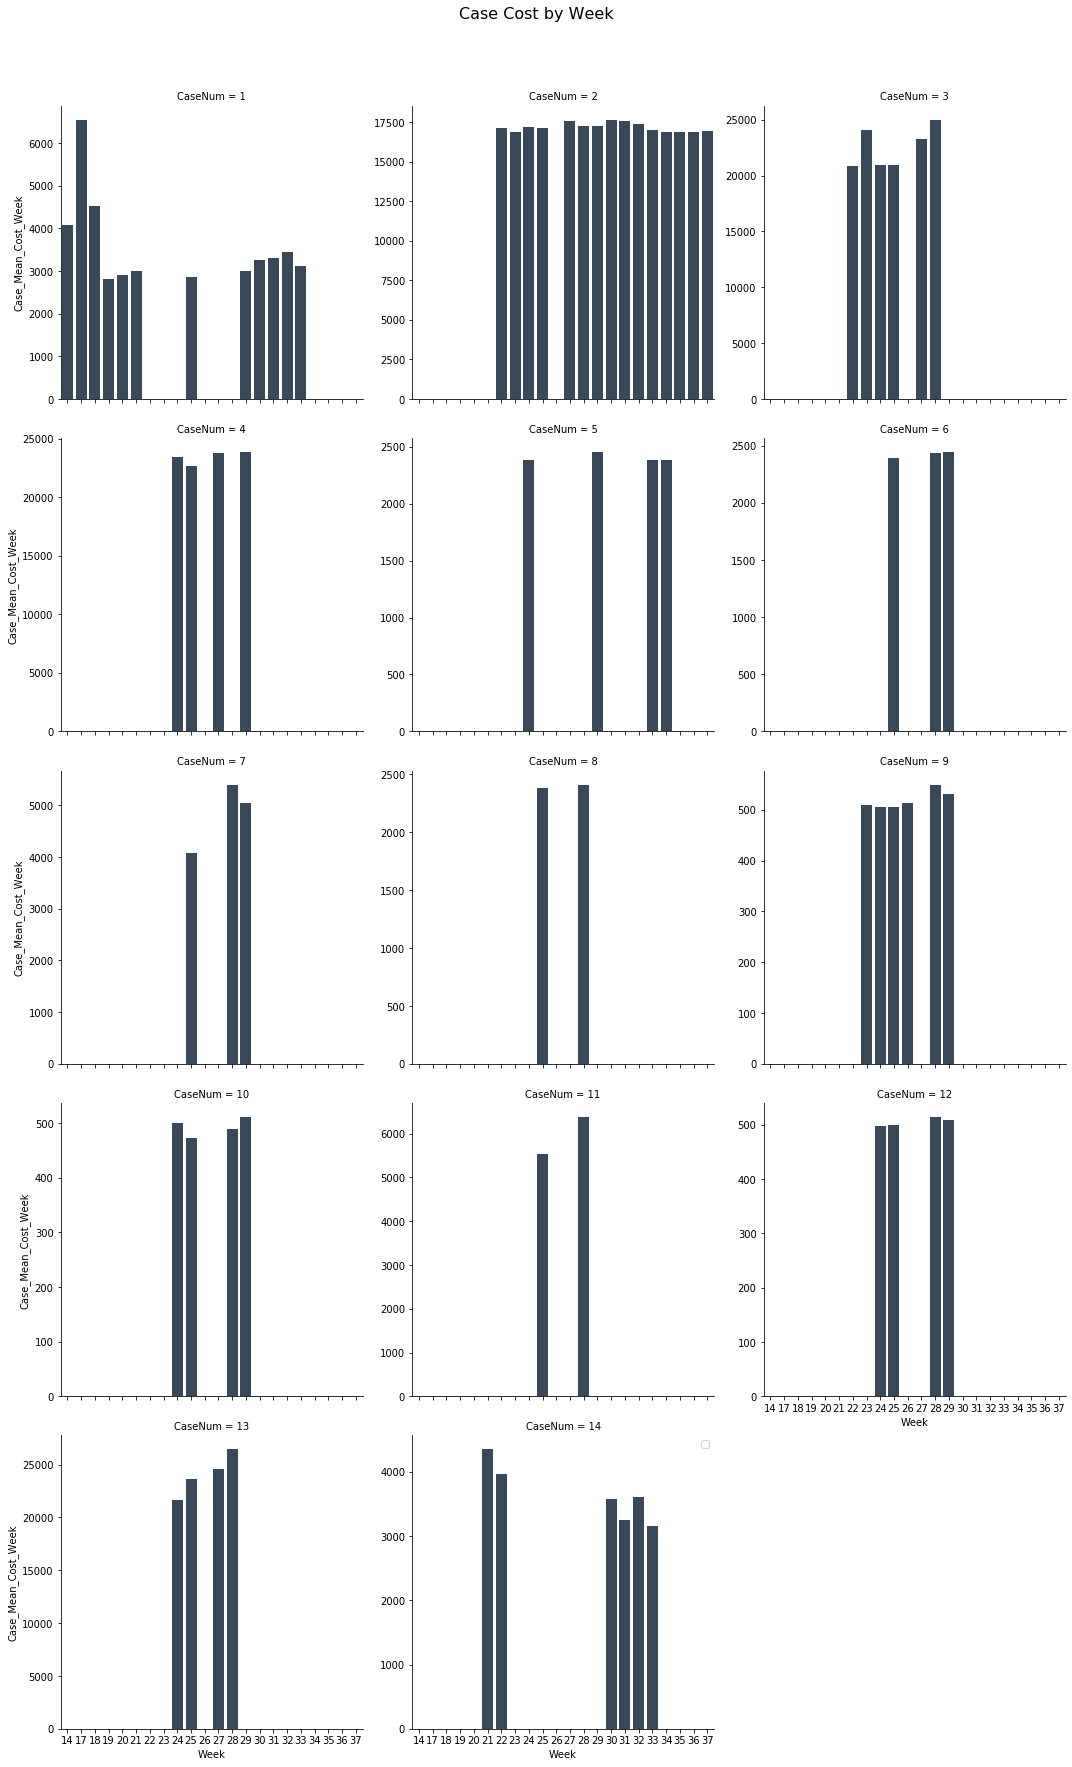

In [122]:
#Plot the mean costs for each week, by week and case
#This plot does NOT share the y axis 
g = sns.factorplot(x='Week',y='Case_Mean_Cost_Week',col='CaseNum',
                   col_wrap=3,data=df_CaseSpan, kind='bar',ci=None,legend=False, color="#34495e", sharey=False)
 
plt.suptitle('Case Cost by Week',size=16)
plt.legend(loc='best')
plt.subplots_adjust(top=.925)
    
plt.show()

In [123]:
Case1_week = df_CaseSpan[df_CaseSpan.CaseNum == 1]
Case1_week_sort = Case1_week.sort_values(by='Week')
Case1_MeanWeek = Case1_week_sort[['CaseNum', 'comp_pes_atm', 'compset', 'Week', 'Case_Mean_Cost_Week']]
Case1_MeanWeek.drop_duplicates(subset=None, keep="first", inplace=True)

In [124]:
Case1_MeanWeek

CaseNum  comp_pes_atm                                            compset  \
68         1          1800  1850_CAM60_CLM50%BGC-CROP_CICE_POP2%ECO_MOSART...   
49         1          1800  1850_CAM60_CLM50%BGC-CROP_CICE_POP2%ECO_MOSART...   
33         1          1800  1850_CAM60_CLM50%BGC-CROP_CICE_POP2%ECO_MOSART...   
54         1          1800  1850_CAM60_CLM50%BGC-CROP_CICE_POP2%ECO_MOSART...   
0          1          1800  1850_CAM60_CLM50%BGC-CROP_CICE_POP2%ECO_MOSART...   
47         1          1800  1850_CAM60_CLM50%BGC-CROP_CICE_POP2%ECO_MOSART...   
66         1          1800  1850_CAM60_CLM50%BGC-CROP_CICE_POP2%ECO_MOSART...   
91         1          1800  1850_CAM60_CLM50%BGC-CROP_CICE_POP2%ECO_MOSART...   
97         1          1800  1850_CAM60_CLM50%BGC-CROP_CICE_POP2%ECO_MOSART...   
112        1          1800  1850_CAM60_CLM50%BGC-CROP_CICE_POP2%ECO_MOSART...   
121        1          1800  1850_CAM60_CLM50%BGC-CROP_CICE_POP2%ECO_MOSART...   
71         1          1800  1850_CAM60_CLM50%BGC-CROP_CICE_POP2%ECO_MOSART...   

     Week  Case_Mean_Cost_Week  
68     14          4092.130000  
49     17          6555.111667  
33     18          4523.760000  
54     19          2819.068571  
0      20          2906.850833  
47     21          3000.224444  
66     25          2852.715000  
91     29          3007.304545  
97     30          3269.296923  
112    31          3304.841818  
121    32          3444.270909  
71     33          3122.997857

In [125]:
Case1_stats = df_CaseSpan[df_CaseSpan.CaseNum == 1]
Case1_stats = Case1_stats.sort_values(by='Week')
Case1_StatsWeek = Case1_stats[['CaseNum', 'comp_pes_atm', 'compset', 'model_cost', 'Week']]
#Case1_MeanWeek.drop_duplicates(subset=None, keep="first", inplace=True)
Case1_StatsWeek.head()

CaseNum  comp_pes_atm                                            compset  \
68        1          1800  1850_CAM60_CLM50%BGC-CROP_CICE_POP2%ECO_MOSART...   
69        1          1800  1850_CAM60_CLM50%BGC-CROP_CICE_POP2%ECO_MOSART...   
70        1          1800  1850_CAM60_CLM50%BGC-CROP_CICE_POP2%ECO_MOSART...   
67        1          1800  1850_CAM60_CLM50%BGC-CROP_CICE_POP2%ECO_MOSART...   
49        1          1800  1850_CAM60_CLM50%BGC-CROP_CICE_POP2%ECO_MOSART...   

    model_cost  Week  
68     3884.23    14  
69     3920.20    14  
70     4304.42    14  
67     4259.67    14  
49     6330.90    17

Levene's test on whether the variance is statistically significant:

In [126]:
#Levene's test checks for homogeneity of variances and the null hypothesis is that all variances are equal. 
#A resulting p-value under 0.05 means that variances are not equal (different distributions)
scipy.stats.levene(Case1_StatsWeek.model_cost, Case1_StatsWeek.Week)

LeveneResult(statistic=38.126278637181144, pvalue=2.5378841167848847e-09)

## Did Pre-Upgrade Performance Eventually Return?

In cases whose model cost was statistically significant after the upgrade, has the model performance returned to that of before the upgrade? I'll compare a case's overall before-upgrade mean to the weekly mean post-upgrade. Leave out cases 2, 5, 6, 10, and 1 and 14 (whose costs improved!):  
  
Take Case_Mean_Cost_BA where Before_After == 1,  
iterate through and compare to Case_Mean_Cost_Week where Before_After == 2

In [127]:
#Statistically Significant cases whose performance decreased
caselist = [3, 4, 7, 8, 9, 11, 12, 13]

#Compare case mean before upgrade to each week after the upgrade
for i in caselist:              #Subsets the case by week and weekly means
    print (' ')
    Case_week = df_CaseSpan[df_CaseSpan.CaseNum == i]
    Case_week_sort = Case_week.sort_values(by='Week')
    Case_MeanWeek = Case_week_sort[['CaseNum', 'comp_pes_atm', 'compset', 'Week', 'Case_Mean_Cost_Week']]
    Case_MeanWeek.drop_duplicates(subset=None, keep="first", inplace=True)

    Case_MeanWeek = Case_MeanWeek[Case_MeanWeek.Week >= 26]      #Takes just the weeks after the upgrade
    
    x = df_CaseSpan.loc[(df_CaseSpan.Before_After=='1') & (df_CaseSpan.CaseNum==i)]  #Takes the mean before the upgrade
    BeforeCost = x.Case_Mean_Cost_BA.unique().item()
    BeforeCost = round(BeforeCost, 2)  
    print ('Case: ', i)                                              #Prints the case
    print ('BeforeCost: ', BeforeCost)                               #Prints the mean cost before the upgrade
    
    for j in Case_MeanWeek.Week:                                     #Takes each week after the upgrade
        WeekCost = Case_MeanWeek[Case_MeanWeek.Week == j]
        y = WeekCost.Case_Mean_Cost_Week.item()   
        y = round(y, 2)
        print ('Week: ', j)                                          #Prints the week number
        print ('Week Mean Cost', y)                                  #Prints the mean cost for that week
        
        if BeforeCost >= y:                                          #Compares overall before mean with each weekly mean
             print('better')                                         #Print 'better' if cost improved
        else:
            perc = (y - BeforeCost)/BeforeCost * 100                 #Calculate the percent change
            perc = round(perc, 2)
            print(perc, '%', 'worse')                                #Print percent change, print 'worse' if cost degraded

 
Case:  3
BeforeCost:  21681.15
Week:  27
Week Mean Cost 23290.21
7.42 % worse
Week:  28
Week Mean Cost 25028.17
15.44 % worse
 
Case:  4
BeforeCost:  22823.56
Week:  27
Week Mean Cost 23796.2
4.26 % worse
Week:  29
Week Mean Cost 23863.69
4.56 % worse
 
Case:  7
BeforeCost:  4087.31
Week:  28
Week Mean Cost 5402.89
32.19 % worse
Week:  29
Week Mean Cost 5050.41
23.56 % worse
 
Case:  8
BeforeCost:  2381.63
Week:  28
Week Mean Cost 2412.98
1.32 % worse
 
Case:  9
BeforeCost:  506.37
Week:  26
Week Mean Cost 514.13
1.53 % worse
Week:  28
Week Mean Cost 549.73
8.56 % worse
Week:  29
Week Mean Cost 531.77
5.02 % worse
 
Case:  11
BeforeCost:  5525.82
Week:  28
Week Mean Cost 6380.26
15.46 % worse
 
Case:  12
BeforeCost:  498.83
Week:  28
Week Mean Cost 514.53
3.15 % worse
Week:  29
Week Mean Cost 509.1
2.06 % worse
 
Case:  13
BeforeCost:  23076.63
Week:  27
Week Mean Cost 24611.73
6.65 % worse
Week:  28
Week Mean Cost 26427.23
14.52 % worse


# BaseSpans

Here I perform some of the same analysis for the BaseCases (ensemble case groups) that spanned the upgrade, of which there are also 14.

In [128]:
df_BaseSpan.shape

(1049, 99)

# EDA and Number of Data Points

Look at the number of data points we have to compare. To do so, we'll add a binary column to each frame where 1 means before the upgrade, and 2 means after:

In [129]:
#Add binary column to df_BaseSpan 1=before upgrade, 2=after
df_BaseSpan.loc[df_BaseSpan.curr_date <= '2019-07-01', 'Before_After'] = '1' 
df_BaseSpan.loc[df_BaseSpan.curr_date >= '2019-07-01', 'Before_After'] = '2' 

In [130]:
df_base_points = df_BaseSpan.groupby(['BaseCase'])['Before_After'].value_counts().to_frame() 

#Set column names
df_base_points.columns = ["Data_Points"]
df_base_points.reset_index() 

BaseCase Before_After  \
0            b.e21.B1850.f09_g17.CMIP6-DAMIP-hist-nat            2   
1            b.e21.B1850.f09_g17.CMIP6-DAMIP-hist-nat            1   
2   b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-wit...            2   
3   b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-wit...            1   
4    b.e21.B1850G.f09_g17_gl4.CMIP6-piControl-withism            1   
5    b.e21.B1850G.f09_g17_gl4.CMIP6-piControl-withism            2   
6             b.e21.B1850cmip6.f09_g17.DAMIP-hist-ghg            1   
7             b.e21.B1850cmip6.f09_g17.DAMIP-hist-ghg            2   
8           b.e21.BSSP245cmip6.f09_g17.CMIP6-SSP2-4.5            1   
9           b.e21.BSSP245cmip6.f09_g17.CMIP6-SSP2-4.5            2   
10  b.e21.BSSP585_BPRPcmip6.f09_g17.CMIP6-esm-ssp5...            2   
11  b.e21.BSSP585_BPRPcmip6.f09_g17.CMIP6-esm-ssp5...            1   
12               b.e21.BWCO2x4.f09_g17.CMIP6-G1-WACCM            1   
13               b.e21.BWCO2x4.f09_g17.CMIP6-G1-WACCM            2   
14   b.e21.BWSSP370cmip6.f09_g17.CMIP6-SSP3-7.0-WACCM            1   
15   b.e21.BWSSP370cmip6.f09_g17.CMIP6-SSP3-7.0-WACCM            2   
16   b.e21.BWSSP585cmip6.f09_g17.CMIP6-SSP5-8.5-WACCM            1   
17   b.e21.BWSSP585cmip6.f09_g17.CMIP6-SSP5-8.5-WACCM            2   
18           f.e21.F1850_BGC.f09_f09_mg17.CFMIP-piSST            2   
19           f.e21.F1850_BGC.f09_f09_mg17.CFMIP-piSST            1   
20           f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-GMMIP            1   
21           f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-GMMIP            2   
22  f.e21.FWaerchem-piCH4.f09_g17.CMIP6-histSST-pi...            2   
23  f.e21.FWaerchem-piCH4.f09_g17.CMIP6-histSST-pi...            1   
24              g.e21.GOMIPECOIAF.T62_g17.CMIP6-omip1            2   
25              g.e21.GOMIPECOIAF.T62_g17.CMIP6-omip1            1   
26        g.e21.GOMIPECOIAF_JRA.TL319_g17.CMIP6-omip2            1   
27        g.e21.GOMIPECOIAF_JRA.TL319_g17.CMIP6-omip2            2   

    Data_Points  
0            20  
1            13  
2            34  
3             6  
4            71  
5            60  
6            17  
7            16  
8             9  
9             9  
10           11  
11            6  
12           85  
13           15  
14          146  
15           25  
16           62  
17           38  
18           31  
19           16  
20           52  
21           35  
22          119  
23           46  
24           34  
25           29  
26           27  
27           17

In [131]:
df_base_points.describe()

Data_Points
count    28.000000
mean     37.464286
std      33.929646
min       6.000000
25%      15.750000
50%      28.000000
75%      47.500000
max     146.000000

To run the statistical test, I need to know whether I'm working with sparse data. For df_CaseSpan, the number of data points per case, per binary ranges from 6 to 119, with a mean of 27. For df_BaseSpan, it ranges from 6 to 146, with a mean of 37. These are on the same scale.

## Normalization of Span Bases

Normalize the model_cost data for bases spanning the upgrade by dividng each model_cost by the average model cost for that base. First, look and see if pre-normalized data is normal for the span bases:

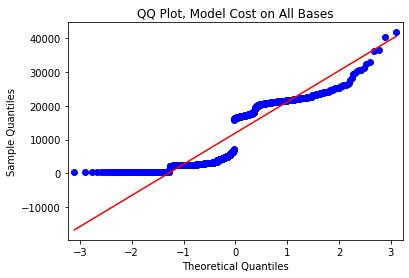

In [132]:
sm.qqplot(df_BaseSpan.model_cost, line='s')
plt.title("QQ Plot, Model Cost on All Bases")
pylab.show()

The data is not normal.

In [133]:
#Normalize the data

# 1. Create a df grouping by base and take the mean (Base_Mean_Cost), then merge onto df_BaseSpan by BaseCase
df_BaseMean = df_BaseSpan.groupby(['BaseCase'])['model_cost'].mean().reset_index(name = "Base_Mean_Cost")
#Append df_BaseSpan with mean cost per BaseCase
df_BaseSpan = pd.merge(df_BaseSpan, df_BaseMean, on=['BaseCase'], how = 'inner') 

# 2. Divide each model_cost by the mean for its Base in a column called Norm_Model_Cost
df_BaseSpan['Norm_Model_Cost'] = df_BaseSpan.model_cost / df_BaseSpan.Base_Mean_Cost

#3. Create before and after dfs
df_before_bases = df_BaseSpan[df_BaseSpan.Before_After == '1']
df_after_bases = df_BaseSpan[df_BaseSpan.Before_After == '2']

Text(0, 0.5, 'Density')

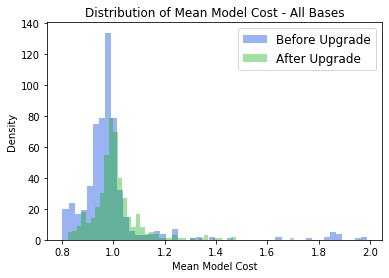

In [134]:
#Plot the before/after distributions of the normalized base data:

sns.distplot(df_before_bases.Norm_Model_Cost,  kde=False, label='Before Upgrade', color=sns.xkcd_rgb["blue"])
sns.distplot(df_after_bases.Norm_Model_Cost,  kde=False,label='After Upgrade', color=sns.xkcd_rgb["green"])

# Plot formatting
plt.legend(prop={'size': 12})
plt.title('Distribution of Mean Model Cost - All Bases')
plt.xlabel('Mean Model Cost')
plt.ylabel('Density')

In [135]:
#import plotly.express as px
    
#Have to put dates in order for some reason
df_DateSort2 = df_BaseSpan.sort_values(by='curr_date')
#Plot
fig = px.line(df_DateSort2, x = 'curr_date', y = 'Norm_Model_Cost', title="Model Cost over Time for Span Bases")

fig.show()

In [136]:
#Calcualte before and After means for normalized data
df_before_bases.Norm_Model_Cost.mean()

0.994844802280682

In [137]:
df_before_bases.Norm_Model_Cost.nunique()

585

In [138]:
df_after_bases.Norm_Model_Cost.mean()

1.0064995488487096

In [139]:
df_after_bases.Norm_Model_Cost.nunique()

464

Text(0.5, 1.0, 'Distribution of Mean Model Cost, Normalized, for Span Bases')

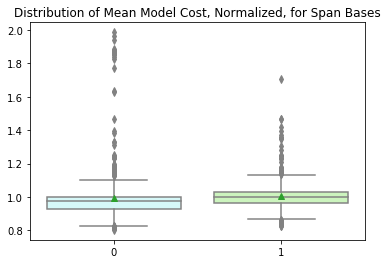

In [140]:
#Before is shown in blue, after in green
sns.boxplot(
    data=[df_before_bases.Norm_Model_Cost, df_after_bases.Norm_Model_Cost],
    palette=[sns.xkcd_rgb["pale blue"], sns.xkcd_rgb["pale green"]],
    showmeans=True)

plt.title('Distribution of Mean Model Cost, Normalized, for Span Bases')

We see that for similar numbers of data points before and after the upgrade, the mean model cost is slightly higher after the upgrade.

## Normality Testing - Normalized Bases

Test the normalized before and after data for normal distribution. This will determine which kinds of statistical testing to pursue.

In [141]:
#KS test for normality - Normalized Before Bases
scipy.stats.kstest(df_before_bases.Norm_Model_Cost, "norm")

KstestResult(statistic=0.7887360875971079, pvalue=0.0)

In [142]:
#KS test for normality - Normalized After Bases
scipy.stats.kstest(df_after_bases.Norm_Model_Cost, "norm")

KstestResult(statistic=0.794844120916955, pvalue=1.2875288646e-314)

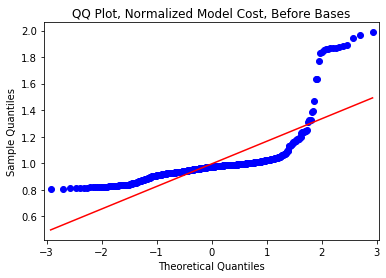

In [143]:
#QQ Plot on Normalized Before Bases
sm.qqplot(df_before_bases.Norm_Model_Cost, line='s')
plt.title('QQ Plot, Normalized Model Cost, Before Bases')
pylab.show()

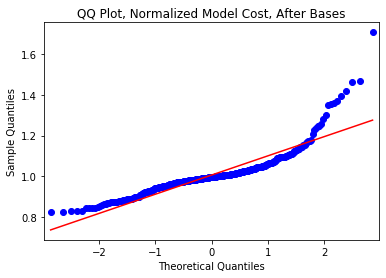

In [144]:
#QQ Plot on Normalized After Bases
sm.qqplot(df_after_bases.Norm_Model_Cost, line='s')
plt.title('QQ Plot, Normalized Model Cost, After Bases')
pylab.show()

With tiny p-values far below 0.05 and qqplots that don't fall close to a straight line, we can say that this data is not normal. 

## Significance Testing - Normalized Bases

We can't do a t-test of other parametric tests on this non-normal data, but we can do non-parametric testing to see if there is a statistically significant difference between the normalized model cost of the groups.

In [145]:
#Kruskal Wallis

#'The Kruskal-Wallis H test (sometimes also called the "one-way ANOVA on ranks") is a rank-based nonparametric test 
#that can be used to determine if there are statistically significant differences between two or more groups 
#of an independent variable on a continuous or ordinal dependent variable.'
#https://statistics.laerd.com/spss-tutorials/kruskal-wallis-h-test-using-spss-statistics.php
scipy.stats.kruskal(df_before_bases.Norm_Model_Cost, df_after_bases.Norm_Model_Cost)

KruskalResult(statistic=56.3108096922233, pvalue=6.1874322599269e-14)

In [146]:
#Mann Whitney U

#'The Mann-Whitney U test is used to compare differences between two independent groups when the dependent 
#variable is either ordinal or continuous, but not normally distributed.'
#https://statistics.laerd.com/spss-tutorials/mann-whitney-u-test-using-spss-statistics.php
scipy.stats.mannwhitneyu(df_before_bases.Norm_Model_Cost, df_after_bases.Norm_Model_Cost, alternative='two-sided')

MannwhitneyuResult(statistic=99149.0, pvalue=6.192279553726118e-14)

In [147]:
#Paired Wilcoxon Signed Rank Test

#The Wilcoxon signed-rank test tests the null hypothesis that two related paired samples come from the same distribution. 
#In particular, it tests whether the distribution of the differences x - y is symmetric about zero. 
#It is a non-parametric version of the paired T-test.

#But the samples must have the same length

#scipy.stats.wilcoxon(before_all.model_cost, after_all.model_cost)

Because the p-values are less than 0.05, we reject the null hypothesis that there's no difference between the means and conclude that a significant difference does exist!

## Examination of Normality and H0 by Base

Now, we can look at whether the data is normal for any particular span base, and also whether the distributions are normal when comparing before and after data by base. For simplicity, we'll assign ordinal numbers for reference and plotting:

In [148]:
#Give BaseCase names new IDs
df_BaseSpan['BaseNum'] = pd.factorize(df_BaseSpan.BaseCase)[0] + 101
df_BaseSpan.BaseNum.unique()

array([101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113,
       114], dtype=int64)

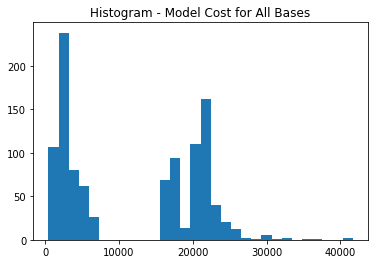

In [149]:
#Histogram Model Cost All Bases
fig = plt.figure()
axes1 = fig.add_subplot(1, 1, 1)
axes1.hist(df_BaseSpan['model_cost'], bins=30)
axes1.set_title('Histogram - Model Cost for All Bases')
fig.show()

In [150]:
#Subset individual Bases
#OK I'm sure there is a better way to do this, but, sometimes the fastest way is the way you know how . . .
Base101 = df_BaseSpan[df_BaseSpan.BaseNum == 101]
Base102 = df_BaseSpan[df_BaseSpan.BaseNum == 102]
Base103 = df_BaseSpan[df_BaseSpan.BaseNum == 103]
Base104 = df_BaseSpan[df_BaseSpan.BaseNum == 104]
Base105 = df_BaseSpan[df_BaseSpan.BaseNum == 105]
Base106 = df_BaseSpan[df_BaseSpan.BaseNum == 106]
Base107 = df_BaseSpan[df_BaseSpan.BaseNum == 107]
Base108 = df_BaseSpan[df_BaseSpan.BaseNum == 108]
Base109 = df_BaseSpan[df_BaseSpan.BaseNum == 109]
Base110 = df_BaseSpan[df_BaseSpan.BaseNum == 110]
Base111 = df_BaseSpan[df_BaseSpan.BaseNum == 111]
Base112 = df_BaseSpan[df_BaseSpan.BaseNum == 112]
Base113 = df_BaseSpan[df_BaseSpan.BaseNum == 113]
Base114 = df_BaseSpan[df_BaseSpan.BaseNum == 114]

Let's look at some qq plots to check the normality of distributions for each base:

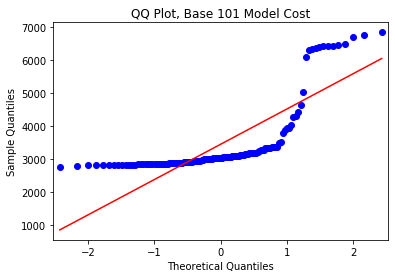

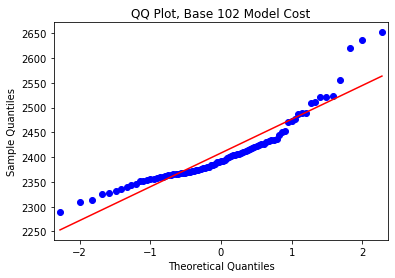

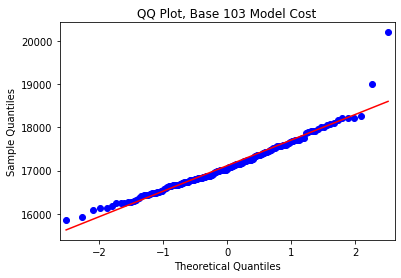

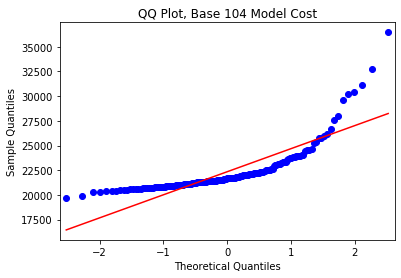

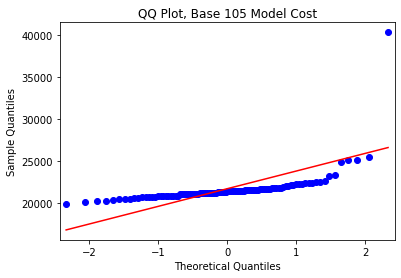

In [151]:
#I'm also sure there has to be a FacetGrid or something I can do for these, but . . . 
sm.qqplot(Base101.model_cost, line='s')
plt.title('QQ Plot, Base 101 Model Cost')
sm.qqplot(Base102.model_cost, line='s')
plt.title('QQ Plot, Base 102 Model Cost')
sm.qqplot(Base103.model_cost, line='s')
plt.title('QQ Plot, Base 103 Model Cost')
sm.qqplot(Base104.model_cost, line='s')
plt.title('QQ Plot, Base 104 Model Cost')
sm.qqplot(Base105.model_cost, line='s')
plt.title('QQ Plot, Base 105 Model Cost')
pylab.show()

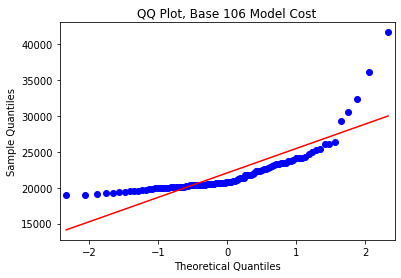

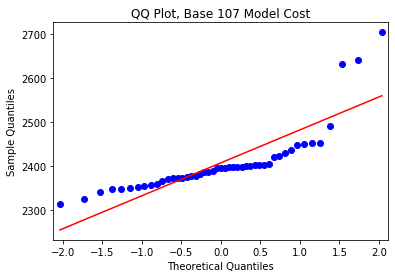

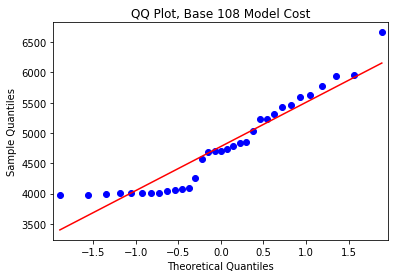

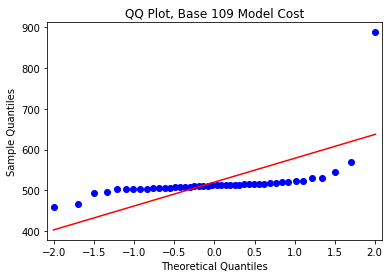

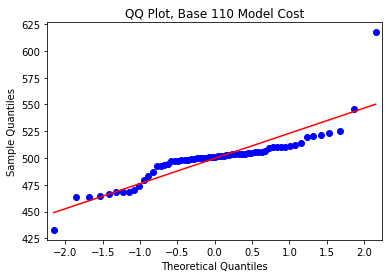

In [152]:
sm.qqplot(Base106.model_cost, line='s')
plt.title('QQ Plot, Base 106 Model Cost')
sm.qqplot(Base107.model_cost, line='s')
plt.title('QQ Plot, Base 107 Model Cost')
sm.qqplot(Base108.model_cost, line='s')
plt.title('QQ Plot, Base 108 Model Cost')
sm.qqplot(Base109.model_cost, line='s')
plt.title('QQ Plot, Base 109 Model Cost')
sm.qqplot(Base110.model_cost, line='s')
plt.title('QQ Plot, Base 110 Model Cost')
pylab.show()

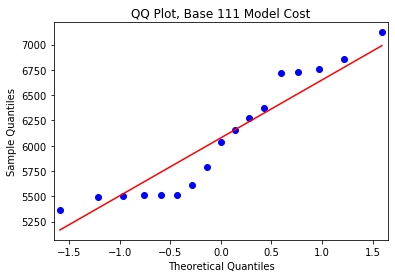

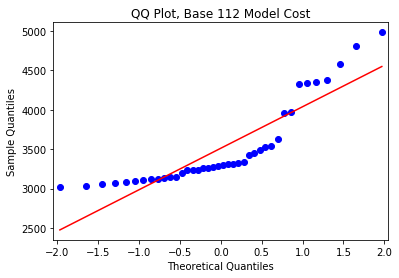

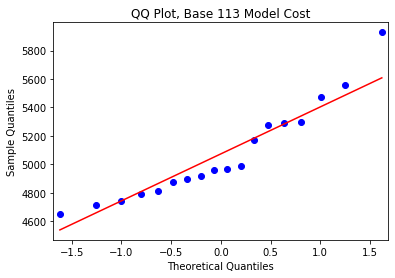

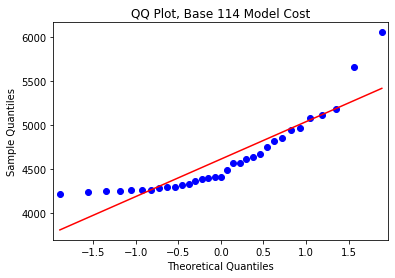

In [153]:
sm.qqplot(Base111.model_cost, line='s')
plt.title('QQ Plot, Base 111 Model Cost')
sm.qqplot(Base112.model_cost, line='s')
plt.title('QQ Plot, Base 112 Model Cost')
sm.qqplot(Base113.model_cost, line='s')
plt.title('QQ Plot, Base 113 Model Cost')
sm.qqplot(Base114.model_cost, line='s')
plt.title('QQ Plot, Base 114 Model Cost')
pylab.show()

So all of these would fail the tests for normality, with the possible exception of Base103, so let's look at that closer:

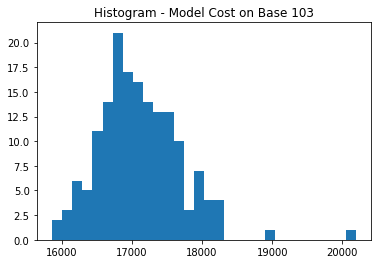

In [154]:
#Histogram Base 103
fig = plt.figure()
axes1 = fig.add_subplot(1, 1, 1)
axes1.hist(Base103['model_cost'], bins=30)
axes1.set_title('Histogram - Model Cost on Base 103')
fig.show()

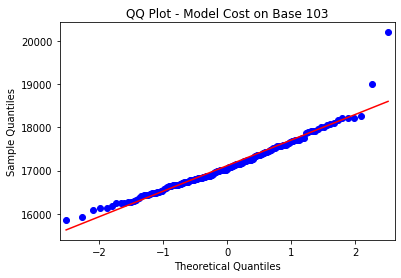

In [155]:
sm.qqplot(Base103.model_cost, line='s')
plt.title('QQ Plot - Model Cost on Base 103')
pylab.show()

In [156]:
#Test all cost from Base103 for normality

#from scipy.stats import shapiro
stat, p = shapiro(Base103.model_cost)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

#https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/

Statistics=0.949, p=0.000
Sample does not look Gaussian (reject H0)


In [157]:
#Test distribution of cost before the upgrade for Base 103

Base103_before = Base103[Base103.Before_After == '1']
 
from scipy.stats import shapiro
stat, p = shapiro(Base103_before.model_cost)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.818, p=0.000
Sample does not look Gaussian (reject H0)


In [158]:
#Test distribution of cost after the upgrade for Base 103

Base103_after = Base103[Base103.Before_After == '2']
 
from scipy.stats import shapiro
stat, p = shapiro(Base103_after.model_cost)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.978, p=0.048
Sample does not look Gaussian (reject H0)


No normal data!

## Statistical Significance Testing - Bases

In [159]:
#Loop through and find KW for each Base:
nums = df_BaseSpan.BaseNum.unique()
df = []

for i in nums:
    df = df_BaseSpan[df_BaseSpan.BaseNum == i]  #Set BaseNum to i, take subset
    df_bef = df[df.Before_After == '1']         #Get Before df
    df_aft = df[df.Before_After == '2']         #Get After df
    KW = scipy.stats.kruskal(df_bef.model_cost, df_aft.model_cost)   #Get Kruskal Wallis output string
     
    kw =str(KW)                       #Convert KW to a string
    p = kw.rpartition('=')[-1]        #Partition KW string at right-most '='
    p = p.strip(')')                  #Strip trailing right parenthesis
    p = float(p)                      #Convert to float. Now we have a numeric p-value
    
    significant = p <= 0.05           #Boolean comparison for significance
    print ('BaseNum: ', i , KW, significant)

BaseNum:  101 KruskalResult(statistic=10.848676909944459, pvalue=0.000988663715158928) True
BaseNum:  102 KruskalResult(statistic=9.602697302697322, pvalue=0.0019429176338887973) True
BaseNum:  103 KruskalResult(statistic=1.0353434197147067, pvalue=0.3089069478055688) False
BaseNum:  104 KruskalResult(statistic=35.0944568333864, pvalue=3.1409361894745673e-09) True
BaseNum:  105 KruskalResult(statistic=5.525105481685728, pvalue=0.018745472734059725) True
BaseNum:  106 KruskalResult(statistic=20.279301106581272, pvalue=6.692066335454196e-06) True
BaseNum:  107 KruskalResult(statistic=3.815020161290306, pvalue=0.05079499384231141) False
BaseNum:  108 KruskalResult(statistic=20.537104072398193, pvalue=5.8486481463722745e-06) True
BaseNum:  109 KruskalResult(statistic=11.468554829339155, pvalue=0.0007078370295733665) True
BaseNum:  110 KruskalResult(statistic=10.953346855983767, pvalue=0.0009343469482468044) True
BaseNum:  111 KruskalResult(statistic=7.36363636363636, pvalue=0.0066556054829

The above analysis shows that the differences in model cost per base are significant for all bases but 103, and 107. Therefore, in 12/14 of the bases (about 86%), the difference was statistically significant. Was it better or worse? We'll look at that next.

## Upgrade Plots - Percent Change

Here I'll take just a few columns to make things easier to think about and look at, and calculate the percent change in before and after performance by base (Base_Mean_Cost_BA).

In [160]:
df_BaseSpan

case  comp_pes_atm  \
0     b.e21.B1850G.f09_g17_gl4.CMIP6-piControl-withi...          1800   
1     b.e21.B1850G.f09_g17_gl4.CMIP6-piControl-withi...          1800   
2     b.e21.B1850G.f09_g17_gl4.CMIP6-piControl-withi...          1800   
3     b.e21.B1850G.f09_g17_gl4.CMIP6-piControl-withi...          1800   
4     b.e21.B1850G.f09_g17_gl4.CMIP6-piControl-withi...          1800   
5     b.e21.B1850G.f09_g17_gl4.CMIP6-piControl-withi...          1800   
6     b.e21.B1850G.f09_g17_gl4.CMIP6-piControl-withi...          1800   
7     b.e21.B1850G.f09_g17_gl4.CMIP6-piControl-withi...          1800   
8     b.e21.B1850G.f09_g17_gl4.CMIP6-piControl-withi...          1800   
9     b.e21.B1850G.f09_g17_gl4.CMIP6-piControl-withi...          1800   
10    b.e21.B1850G.f09_g17_gl4.CMIP6-piControl-withi...          1800   
11    b.e21.B1850G.f09_g17_gl4.CMIP6-piControl-withi...          1800   
12    b.e21.B1850G.f09_g17_gl4.CMIP6-piControl-withi...          1800   
13    b.e21.B1850G.f09_g17_gl4.CMIP6-piControl-withi...          1800   
14    b.e21.B1850G.f09_g17_gl4.CMIP6-piControl-withi...          1800   
15    b.e21.B1850G.f09_g17_gl4.CMIP6-piControl-withi...          1800   
16    b.e21.B1850G.f09_g17_gl4.CMIP6-piControl-withi...          1800   
17    b.e21.B1850G.f09_g17_gl4.CMIP6-piControl-withi...          1800   
18    b.e21.B1850G.f09_g17_gl4.CMIP6-piControl-withi...          1800   
19    b.e21.B1850G.f09_g17_gl4.CMIP6-piControl-withi...          1800   
20    b.e21.B1850G.f09_g17_gl4.CMIP6-piControl-withi...          1800   
21    b.e21.B1850G.f09_g17_gl4.CMIP6-piControl-withi...          1800   
22    b.e21.B1850G.f09_g17_gl4.CMIP6-piControl-withi...          1800   
23    b.e21.B1850G.f09_g17_gl4.CMIP6-piControl-withi...          1800   
24    b.e21.B1850G.f09_g17_gl4.CMIP6-piControl-withi...          1800   
25    b.e21.B1850G.f09_g17_gl4.CMIP6-piControl-withi...          1800   
26    b.e21.B1850G.f09_g17_gl4.CMIP6-piControl-withi...          1800   
27    b.e21.B1850G.f09_g17_gl4.CMIP6-piControl-withi...          1800   
28    b.e21.B1850G.f09_g17_gl4.CMIP6-piControl-withi...          1800   
29    b.e21.B1850G.f09_g17_gl4.CMIP6-piControl-withi...          1800   
...                                                 ...           ...   
1019        b.e21.B1850cmip6.f09_g17.DAMIP-hist-ghg.001          3456   
1020        b.e21.B1850cmip6.f09_g17.DAMIP-hist-ghg.001          3456   
1021        b.e21.B1850cmip6.f09_g17.DAMIP-hist-ghg.003          3456   
1022        b.e21.B1850cmip6.f09_g17.DAMIP-hist-ghg.003          3456   
1023        b.e21.B1850cmip6.f09_g17.DAMIP-hist-ghg.001          3456   
1024        b.e21.B1850cmip6.f09_g17.DAMIP-hist-ghg.001          3456   
1025        b.e21.B1850cmip6.f09_g17.DAMIP-hist-ghg.001          3456   
1026        b.e21.B1850cmip6.f09_g17.DAMIP-hist-ghg.001          3456   
1027        b.e21.B1850cmip6.f09_g17.DAMIP-hist-ghg.001          3456   
1028        b.e21.B1850cmip6.f09_g17.DAMIP-hist-ghg.001          3456   
1029        b.e21.B1850cmip6.f09_g17.DAMIP-hist-ghg.003          3456   
1030        b.e21.B1850cmip6.f09_g17.DAMIP-hist-ghg.003          3456   
1031        b.e21.B1850cmip6.f09_g17.DAMIP-hist-ghg.003          3456   
1032        b.e21.B1850cmip6.f09_g17.DAMIP-hist-ghg.001          3456   
1033        b.e21.B1850cmip6.f09_g17.DAMIP-hist-ghg.003          3456   
1034        b.e21.B1850cmip6.f09_g17.DAMIP-hist-ghg.001          3456   
1035        b.e21.B1850cmip6.f09_g17.DAMIP-hist-ghg.003          3456   
1036        b.e21.B1850cmip6.f09_g17.DAMIP-hist-ghg.003          3456   
1037        b.e21.B1850cmip6.f09_g17.DAMIP-hist-ghg.001          3456   
1038        b.e21.B1850cmip6.f09_g17.DAMIP-hist-ghg.003          3456   
1039        b.e21.B1850cmip6.f09_g17.DAMIP-hist-ghg.003          3456   
1040        b.e21.B1850cmip6.f09_g17.DAMIP-hist-ghg.001          3456   
1041        b.e21.B1850cmip6.f09_g17.DAMIP-hist-ghg.001          3456   
1042        b.e21.B1850cmip6.f09_g17

In [161]:
#Create a df grouping by base, calculate mean before/after
df_before_after2 = df_BaseSpan.groupby(['BaseCase', 'Before_After'])['model_cost'].mean().reset_index(name = "Base_Mean_Cost_BA")
#Append df_BaseSpan with Before_After column
df_BaseSpan = pd.merge(df_BaseSpan, df_before_after2, on=['BaseCase', 'Before_After'], how = 'inner')  

In [162]:
df_BaseSpan

case  comp_pes_atm  \
0     b.e21.B1850G.f09_g17_gl4.CMIP6-piControl-withi...          1800   
1     b.e21.B1850G.f09_g17_gl4.CMIP6-piControl-withi...          1800   
2     b.e21.B1850G.f09_g17_gl4.CMIP6-piControl-withi...          1800   
3     b.e21.B1850G.f09_g17_gl4.CMIP6-piControl-withi...          1800   
4     b.e21.B1850G.f09_g17_gl4.CMIP6-piControl-withi...          1800   
5     b.e21.B1850G.f09_g17_gl4.CMIP6-piControl-withi...          1800   
6     b.e21.B1850G.f09_g17_gl4.CMIP6-piControl-withi...          1800   
7     b.e21.B1850G.f09_g17_gl4.CMIP6-piControl-withi...          1800   
8     b.e21.B1850G.f09_g17_gl4.CMIP6-piControl-withi...          1800   
9     b.e21.B1850G.f09_g17_gl4.CMIP6-piControl-withi...          1800   
10    b.e21.B1850G.f09_g17_gl4.CMIP6-piControl-withi...          1800   
11    b.e21.B1850G.f09_g17_gl4.CMIP6-piControl-withi...          1800   
12    b.e21.B1850G.f09_g17_gl4.CMIP6-piControl-withi...          1800   
13    b.e21.B1850G.f09_g17_gl4.CMIP6-piControl-withi...          1800   
14    b.e21.B1850G.f09_g17_gl4.CMIP6-piControl-withi...          1800   
15    b.e21.B1850G.f09_g17_gl4.CMIP6-piControl-withi...          1800   
16    b.e21.B1850G.f09_g17_gl4.CMIP6-piControl-withi...          1800   
17    b.e21.B1850G.f09_g17_gl4.CMIP6-piControl-withi...          1800   
18    b.e21.B1850G.f09_g17_gl4.CMIP6-piControl-withi...          1800   
19    b.e21.B1850G.f09_g17_gl4.CMIP6-piControl-withi...          1800   
20    b.e21.B1850G.f09_g17_gl4.CMIP6-piControl-withi...          1800   
21    b.e21.B1850G.f09_g17_gl4.CMIP6-piControl-withi...          1800   
22    b.e21.B1850G.f09_g17_gl4.CMIP6-piControl-withi...          1800   
23    b.e21.B1850G.f09_g17_gl4.CMIP6-piControl-withi...          1800   
24    b.e21.B1850G.f09_g17_gl4.CMIP6-piControl-withi...          1800   
25    b.e21.B1850G.f09_g17_gl4.CMIP6-piControl-withi...          1800   
26    b.e21.B1850G.f09_g17_gl4.CMIP6-piControl-withi...          1800   
27    b.e21.B1850G.f09_g17_gl4.CMIP6-piControl-withi...          1800   
28    b.e21.B1850G.f09_g17_gl4.CMIP6-piControl-withi...          1800   
29    b.e21.B1850G.f09_g17_gl4.CMIP6-piControl-withi...          1800   
...                                                 ...           ...   
1019        b.e21.B1850cmip6.f09_g17.DAMIP-hist-ghg.003          3456   
1020        b.e21.B1850cmip6.f09_g17.DAMIP-hist-ghg.003          3456   
1021        b.e21.B1850cmip6.f09_g17.DAMIP-hist-ghg.003          3456   
1022        b.e21.B1850cmip6.f09_g17.DAMIP-hist-ghg.003          3456   
1023        b.e21.B1850cmip6.f09_g17.DAMIP-hist-ghg.003          3456   
1024        b.e21.B1850cmip6.f09_g17.DAMIP-hist-ghg.003          3456   
1025        b.e21.B1850cmip6.f09_g17.DAMIP-hist-ghg.003          3456   
1026        b.e21.B1850cmip6.f09_g17.DAMIP-hist-ghg.003          3456   
1027        b.e21.B1850cmip6.f09_g17.DAMIP-hist-ghg.003          3456   
1028        b.e21.B1850cmip6.f09_g17.DAMIP-hist-ghg.003          3456   
1029        b.e21.B1850cmip6.f09_g17.DAMIP-hist-ghg.003          3456   
1030        b.e21.B1850cmip6.f09_g17.DAMIP-hist-ghg.003          3456   
1031        b.e21.B1850cmip6.f09_g17.DAMIP-hist-ghg.003          3456   
1032        b.e21.B1850cmip6.f09_g17.DAMIP-hist-ghg.001          3456   
1033        b.e21.B1850cmip6.f09_g17.DAMIP-hist-ghg.001          3456   
1034        b.e21.B1850cmip6.f09_g17.DAMIP-hist-ghg.001          3456   
1035        b.e21.B1850cmip6.f09_g17.DAMIP-hist-ghg.001          3456   
1036        b.e21.B1850cmip6.f09_g17.DAMIP-hist-ghg.001          3456   
1037        b.e21.B1850cmip6.f09_g17.DAMIP-hist-ghg.001          3456   
1038        b.e21.B1850cmip6.f09_g17.DAMIP-hist-ghg.001          3456   
1039        b.e21.B1850cmip6.f09_g17.DAMIP-hist-ghg.001          3456   
1040        b.e21.B1850cmip6.f09_g17.DAMIP-hist-ghg.001          3456   
1041        b.e21.B1850cmip6.f09_g17.DAMIP-hist-ghg.001          3456   
1042        b.e21.B1850cmip6.f09_g17

In [163]:
#Subset by before/after and base
df_BaseSet = df_BaseSpan[['BaseNum', 'comp_pes_atm', 'compset', 'Before_After', 'Base_Mean_Cost_BA']]
df_BaseSet.drop_duplicates(subset=None, keep="first", inplace=True)

#There are two occurences of Before on Base 104, due to an extra space in the case name, 
#which is otherwise the same. Delete one of the rows:
df_BaseSet.drop(383, inplace=True)

with pd.option_context('max.colwidth', 1000):
    display(df_BaseSet)

BaseNum  comp_pes_atm  \
0         101          1800   
71        101          1800   
131       102          1728   
183       102          1728   
218       103          1728   
264       103          1728   
385       104          3456   
529       104          3456   
554       105          3456   
616       105          3456   
654       106          3456   
739       106          3456   
754       107          1728   
785       107          1728   
801       108          3456   
814       108          3456   
834       109            72   
861       109            72   
878       110            72   
912       110            72   
941       111          3456   
947       111          3456   
958       112          1800   
992       112          1800   
998       113          3456   
1007      113          3456   
1016      114          3456   
1032      114          3456   

                                                                                                     compset  \
0                                   1850_CAM60_CLM50%BGC-CROP_CICE_POP2%ECO_MOSART_CISM2%EVOLVE_WW3_BGC%BDRD   
71                                  1850_CAM60_CLM50%BGC-CROP_CICE_POP2%ECO_MOSART_CISM2%EVOLVE_WW3_BGC%BDRD   
131                                  HIST_CAM60_CLM50%BGC-CROP_CICE%PRES_DOCN%DOM_MOSART_CISM2%NOEVOLVE_SWAV   
183                                  HIST_CAM60_CLM50%BGC-CROP_CICE%PRES_DOCN%DOM_MOSART_CISM2%NOEVOLVE_SWAV   
218               HIST_CAM60%WCTS%AERCHEM-piCH4_CLM50%BGC-CROP_CICE%PRES_DOCN%DOM_MOSART_CISM2%NOEVOLVE_SWAV   
264               HIST_CAM60%WCTS%AERCHEM-piCH4_CLM50%BGC-CROP_CICE%PRES_DOCN%DOM_MOSART_CISM2%NOEVOLVE_SWAV   
385       SSP370_CAM60%WCTS_CLM50%BGC-CROP-CMIP6WACCMDECK_CICE%CMIP6_POP2%ECO%NDEP_MOSART_CISM2%NOEVOLVE_WW3   
529       SSP370_CAM60%WCTS_CLM50%BGC-CROP-CMIP6WACCMDECK_CICE%CMIP6_POP2%ECO%NDEP_MOSART_CISM2%NOEVOLVE_WW3   
554       SSP585_CAM60%WCTS_CLM50%BGC-CROP-CMIP6WACCMDECK_CICE%CMIP6_POP2%ECO%NDEP_MOSART_CISM2%NOEVOLVE_WW3   
616       SSP585_CAM60%WCTS_CLM50%BGC-CROP-CMIP6WACCMDECK_CICE%CMIP6_POP2%ECO%NDEP_MOSART_CISM2%NOEVOLVE_WW3   
654   1850_CAM60%WCTS%4xCO2_CLM50%BGC-CROP-CMIP6WACCMDECK_CICE%CMIP6_POP2%ECO%NDEP_MOSART_CISM2%NOEVOLVE_WW3   
739   1850_CAM60%WCTS%4xCO2_CLM50%BGC-CROP-CMIP6WACCMDECK_CICE%CMIP6_POP2%ECO%NDEP_MOSART_CISM2%NOEVOLVE_WW3   
754                                  1850_CAM60_CLM50%BGC-CROP_CICE%PRES_DOCN%DOM_MOSART_CISM2%NOEVOLVE_SWAV   
785                                  1850_CAM60_CLM50%BGC-CROP_CICE%PRES_DOCN%DOM_MOSART_CISM2%NOEVOLVE_SWAV   
801      1850_CAM60_CLM50%BGC-CROP-CMIP6DECK_CICE%CMIP6_POP2%ECO%ABIO-DIC_MOSART_CISM2%NOEVOLVE_WW3_BGC%BDRD   
814      1850_CAM60_CLM50%BGC-CROP-CMIP6DECK_CICE%CMIP6_POP2%ECO%ABIO-DIC_MOSART_CISM2%NOEVOLVE_WW3_BGC%BDRD   
834                                                       OMIP_DATM%JRA_SLND_CICE_POP2%ECO_DROF%JRA_SGLC_WW3   
861                                                       OMIP_DATM%JRA_SLND_CICE_POP2%ECO_DROF%JRA_SGLC_WW3   
878                                                       OMIP_DATM%IAF_SLND_CICE_POP2%ECO_DROF%IAF_SGLC_WW3   
912                                                       OMIP_DATM%IAF_SLND_CICE_POP2%ECO_DROF%IAF_SGLC_WW3   
941    SSP585_CAM60_CLM50%BGC-CROP-CMIP6DECK_CICE%CMIP6_POP2%ECO%ABIO-DIC_MOSART_CISM2%NOEVOLVE_WW3_BGC%BPRP   
947    SSP585_CAM60_CLM50%BGC-CROP-CMIP6DECK_CICE%CMIP6_POP2%ECO%ABIO-DIC_MOSART_CISM2%NOEVOLVE_WW3_BGC%BPRP   
958                      1850_CAM60%1PCT_CLM50%BGC-CROP_CICE%CMIP6_POP2%ECO_MOSART_CISM2%EVOLVE_WW3_BGC%BDRD   
992                      1850_CAM60%1PCT_CLM50%BGC-CROP_CICE%CMIP6_POP2%ECO_MOSART_CISM2%EVOLVE_WW3_BGC%BDRD   
998    SSP245_CAM60_CLM50%BGC-CROP-CMIP6DECK_CICE%CMIP6_POP2%ECO%ABIO-DIC_MOSART_CISM2%NOEVOLVE_WW3_BGC%BDRD   
1007   SSP245_CAM60_CLM50%BGC-CROP-CMIP6DECK_CICE%CMIP6_POP2%ECO%ABIO-DIC_MOSART_CISM2%NOEVOLVE_WW3_BGC%BDRD   
1016     1850_CAM60_CLM50%BGC-CROP-CMIP6DECK_CICE%CMIP6_POP2%ECO%ABIO-DIC_MOSART_C

In [164]:
#Subset before data
df_BaseDiff_Before = df_BaseSet[df_BaseSet.Before_After =='1']
df_BaseDiff_Before

BaseNum  comp_pes_atm  \
0         101          1800   
131       102          1728   
218       103          1728   
385       104          3456   
554       105          3456   
654       106          3456   
785       107          1728   
801       108          3456   
834       109            72   
912       110            72   
941       111          3456   
992       112          1800   
998       113          3456   
1032      114          3456   

                                                compset Before_After  \
0     1850_CAM60_CLM50%BGC-CROP_CICE_POP2%ECO_MOSART...            1   
131   HIST_CAM60_CLM50%BGC-CROP_CICE%PRES_DOCN%DOM_M...            1   
218   HIST_CAM60%WCTS%AERCHEM-piCH4_CLM50%BGC-CROP_C...            1   
385   SSP370_CAM60%WCTS_CLM50%BGC-CROP-CMIP6WACCMDEC...            1   
554   SSP585_CAM60%WCTS_CLM50%BGC-CROP-CMIP6WACCMDEC...            1   
654   1850_CAM60%WCTS%4xCO2_CLM50%BGC-CROP-CMIP6WACC...            1   
785   1850_CAM60_CLM50%BGC-CROP_CICE%PRES_DOCN%DOM_M...            1   
801   1850_CAM60_CLM50%BGC-CROP-CMIP6DECK_CICE%CMIP6...            1   
834   OMIP_DATM%JRA_SLND_CICE_POP2%ECO_DROF%JRA_SGLC...            1   
912   OMIP_DATM%IAF_SLND_CICE_POP2%ECO_DROF%IAF_SGLC...            1   
941   SSP585_CAM60_CLM50%BGC-CROP-CMIP6DECK_CICE%CMI...            1   
992   1850_CAM60%1PCT_CLM50%BGC-CROP_CICE%CMIP6_POP2...            1   
998   SSP245_CAM60_CLM50%BGC-CROP-CMIP6DECK_CICE%CMI...            1   
1032  1850_CAM60_CLM50%BGC-CROP-CMIP6DECK_CICE%CMIP6...            1   

      Base_Mean_Cost_BA  
0           3622.138028  
131         2395.890962  
218        17052.681957  
385        21966.883904  
554        22019.156774  
654        21681.152941  
785         2382.045000  
801         4087.313846  
834          506.373704  
912          492.721724  
941         5525.816667  
992         4220.516667  
998         4967.372222  
1032        4457.415294

In [165]:
#Subset after data
df_BaseDiff_After = df_BaseSet[df_BaseSet.Before_After == '2']
df_BaseDiff_After

BaseNum  comp_pes_atm  \
71        101          1800   
183       102          1728   
264       103          1728   
529       104          3456   
616       105          3456   
739       106          3456   
754       107          1728   
814       108          3456   
861       109            72   
878       110            72   
947       111          3456   
958       112          1800   
1007      113          3456   
1016      114          3456   

                                                compset Before_After  \
71    1850_CAM60_CLM50%BGC-CROP_CICE_POP2%ECO_MOSART...            2   
183   HIST_CAM60_CLM50%BGC-CROP_CICE%PRES_DOCN%DOM_M...            2   
264   HIST_CAM60%WCTS%AERCHEM-piCH4_CLM50%BGC-CROP_C...            2   
529   SSP370_CAM60%WCTS_CLM50%BGC-CROP-CMIP6WACCMDEC...            2   
616   SSP585_CAM60%WCTS_CLM50%BGC-CROP-CMIP6WACCMDEC...            2   
739   1850_CAM60%WCTS%4xCO2_CLM50%BGC-CROP-CMIP6WACC...            2   
754   1850_CAM60_CLM50%BGC-CROP_CICE%PRES_DOCN%DOM_M...            2   
814   1850_CAM60_CLM50%BGC-CROP-CMIP6DECK_CICE%CMIP6...            2   
861   OMIP_DATM%JRA_SLND_CICE_POP2%ECO_DROF%JRA_SGLC...            2   
878   OMIP_DATM%IAF_SLND_CICE_POP2%ECO_DROF%IAF_SGLC...            2   
947   SSP585_CAM60_CLM50%BGC-CROP-CMIP6DECK_CICE%CMI...            2   
958   1850_CAM60%1PCT_CLM50%BGC-CROP_CICE%CMIP6_POP2...            2   
1007  SSP245_CAM60_CLM50%BGC-CROP-CMIP6DECK_CICE%CMI...            2   
1016  1850_CAM60_CLM50%BGC-CROP-CMIP6DECK_CICE%CMIP6...            2   

      Base_Mean_Cost_BA  
71          3225.723667  
183         2426.956000  
264        17139.674958  
529        24577.750400  
616        21181.924737  
739        24217.121333  
754         2419.848065  
814         5226.652000  
861          542.335882  
878          505.579412  
947         6380.260000  
958         3387.858235  
1007        5181.068889  
1016        4781.642500

In [166]:
#Calculate Percent Change per base
diff_list2 = []
for i in df_BaseDiff_Before.BaseNum:        #Iterates through each base 
    x = df_BaseDiff_Before.Base_Mean_Cost_BA[df_BaseDiff_Before.BaseNum == i].item()  #Takes the before mean cost
    y = df_BaseDiff_After.Base_Mean_Cost_BA[df_BaseDiff_After.BaseNum == i].item()    #Takes the after mean cost
    diff2 = (y-x)/x*100                      #Calculates the percent change
    diff_list2.append(diff2)                  #Creates a list of percent changes

In [167]:
#Create a df with BaseNum and its percent change in mean cost before/after
df_diff_list2 = pd.DataFrame(data = diff_list2 , columns=['MeanPercDiff']).reset_index()  
df_diff_list2.columns = ['BaseNum', 'MeanPercDiff']
df_diff_list2['BaseNum'] = pd.factorize(df_diff_list2.BaseNum)[0] + 101
df_diff_list2

BaseNum  MeanPercDiff
0       101    -10.944209
1       102      1.296597
2       103      0.510143
3       104     11.885466
4       105     -3.802289
5       106     11.696649
6       107      1.587000
7       108     27.874986
8       109      7.101905
9       110      2.609523
10      111     15.462752
11      112    -19.728827
12      113      4.302006
13      114      7.273884

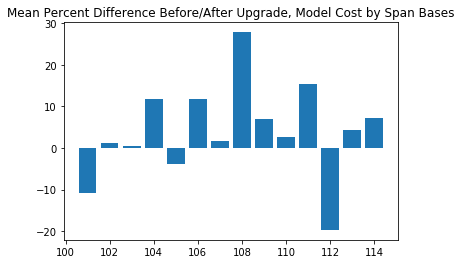

In [168]:
#Plot percent change per Base 
#Create bars
plt.bar(df_diff_list2.BaseNum, df_diff_list2.MeanPercDiff)
plt.title('Mean Percent Difference Before/After Upgrade, Model Cost by Span Bases')
# Show graphic
plt.show()

Remember from above, the statistical testing showed that the differences in before/after model cost for bases 103 and 107 were not statistically significant. Indeed, they show a small percent change. We might look at base 102, which also had a small percent change however, the change was significant. For bases 101 and 112, the change was for the better. For the others, it was worse.

In [169]:
#Append df_BaseDiff_Before with MeanPercDiff
df_diff_new2 = pd.merge(df_BaseDiff_Before, df_diff_list2, on=['BaseNum'], how = 'inner')
del df_diff_new2['Before_After']
del df_diff_new2['Base_Mean_Cost_BA']
df_diff_new2

BaseNum  comp_pes_atm                                            compset  \
0       101          1800  1850_CAM60_CLM50%BGC-CROP_CICE_POP2%ECO_MOSART...   
1       102          1728  HIST_CAM60_CLM50%BGC-CROP_CICE%PRES_DOCN%DOM_M...   
2       103          1728  HIST_CAM60%WCTS%AERCHEM-piCH4_CLM50%BGC-CROP_C...   
3       104          3456  SSP370_CAM60%WCTS_CLM50%BGC-CROP-CMIP6WACCMDEC...   
4       105          3456  SSP585_CAM60%WCTS_CLM50%BGC-CROP-CMIP6WACCMDEC...   
5       106          3456  1850_CAM60%WCTS%4xCO2_CLM50%BGC-CROP-CMIP6WACC...   
6       107          1728  1850_CAM60_CLM50%BGC-CROP_CICE%PRES_DOCN%DOM_M...   
7       108          3456  1850_CAM60_CLM50%BGC-CROP-CMIP6DECK_CICE%CMIP6...   
8       109            72  OMIP_DATM%JRA_SLND_CICE_POP2%ECO_DROF%JRA_SGLC...   
9       110            72  OMIP_DATM%IAF_SLND_CICE_POP2%ECO_DROF%IAF_SGLC...   
10      111          3456  SSP585_CAM60_CLM50%BGC-CROP-CMIP6DECK_CICE%CMI...   
11      112          1800  1850_CAM60%1PCT_CLM50%BGC-CROP_CICE%CMIP6_POP2...   
12      113          3456  SSP245_CAM60_CLM50%BGC-CROP-CMIP6DECK_CICE%CMI...   
13      114          3456  1850_CAM60_CLM50%BGC-CROP-CMIP6DECK_CICE%CMIP6...   

    MeanPercDiff  
0     -10.944209  
1       1.296597  
2       0.510143  
3      11.885466  
4      -3.802289  
5      11.696649  
6       1.587000  
7      27.874986  
8       7.101905  
9       2.609523  
10     15.462752  
11    -19.728827  
12      4.302006  
13      7.273884

In [170]:
import plotly.express as px
df_diff_new2['comp_pes_atm'] = df_diff_new2['comp_pes_atm'].apply(str)
fig = px.bar(df_diff_new2, x = 'BaseNum', y = 'MeanPercDiff', color = 'comp_pes_atm', \
            title ="Mean Percent Difference Before/After Upgrade, Model Cost by Span Bases")
fig.update_xaxes(tickvals=[101,102,103,104,105,106,107,108,109,110,111,112,113,114])
fig.show()

In [171]:
#Identify which bases improved:

subset101 = df_BaseSpan[df_BaseSpan.BaseNum ==101]
print("Base 101 name: " , subset101.BaseCase.unique())
print("Base 101 compset:", subset101.compset.unique())
print("Base 101 comp_pes_atm", subset101.comp_pes_atm.unique())

Base 101 name:  ['b.e21.B1850G.f09_g17_gl4.CMIP6-piControl-withism']
Base 101 compset: ['1850_CAM60_CLM50%BGC-CROP_CICE_POP2%ECO_MOSART_CISM2%EVOLVE_WW3_BGC%BDRD']
Base 101 comp_pes_atm [1800]


In [172]:
#Identify which bases improved:

subset112 = df_BaseSpan[df_BaseSpan.BaseNum ==112]
print("Base 112 name: " , subset112.BaseCase.unique())
print("Base 112 compset:", subset112.compset.unique())
print("Base 112 comp_pes_atm", subset112.comp_pes_atm.unique())

Base 112 name:  ['b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism']
Base 112 compset: ['1850_CAM60%1PCT_CLM50%BGC-CROP_CICE%CMIP6_POP2%ECO_MOSART_CISM2%EVOLVE_WW3_BGC%BDRD']
Base 112 comp_pes_atm [1800]


Look at variation within ensembles:

In [173]:
fig = px.box(df_BaseSpan, x="BaseNum", y="model_cost", color='comp_pes_atm', \
            title='Model Cost Variation by Span Base')
fig.update_xaxes(tickvals=[101,102,103,104,105,106,107,108,109,110,111,112,113,114])
fig.show()

# High-Level Counts 

## Compsets

In [174]:
df_NoOutlier.compset.nunique()

52

In [175]:
#Get unique compsets
print("Unique Compsets:", len(df_CaseSpan.compset.unique()) )
df_CaseSpan.compset.unique()

Unique Compsets: 11


array(['1850_CAM60_CLM50%BGC-CROP_CICE_POP2%ECO_MOSART_CISM2%EVOLVE_WW3_BGC%BDRD',
       'HIST_CAM60%WCTS%AERCHEM-piCH4_CLM50%BGC-CROP_CICE%PRES_DOCN%DOM_MOSART_CISM2%NOEVOLVE_SWAV',
       '1850_CAM60%WCTS%4xCO2_CLM50%BGC-CROP-CMIP6WACCMDECK_CICE%CMIP6_POP2%ECO%NDEP_MOSART_CISM2%NOEVOLVE_WW3',
       'SSP370_CAM60%WCTS_CLM50%BGC-CROP-CMIP6WACCMDECK_CICE%CMIP6_POP2%ECO%NDEP_MOSART_CISM2%NOEVOLVE_WW3',
       '1850_CAM60_CLM50%BGC-CROP_CICE%PRES_DOCN%DOM_MOSART_CISM2%NOEVOLVE_SWAV',
       'HIST_CAM60_CLM50%BGC-CROP_CICE%PRES_DOCN%DOM_MOSART_CISM2%NOEVOLVE_SWAV',
       '1850_CAM60_CLM50%BGC-CROP-CMIP6DECK_CICE%CMIP6_POP2%ECO%ABIO-DIC_MOSART_CISM2%NOEVOLVE_WW3_BGC%BDRD',
       'OMIP_DATM%JRA_SLND_CICE_POP2%ECO_DROF%JRA_SGLC_WW3',
       'OMIP_DATM%IAF_SLND_CICE_POP2%ECO_DROF%IAF_SGLC_WW3',
       'SSP585_CAM60_CLM50%BGC-CROP-CMIP6DECK_CICE%CMIP6_POP2%ECO%ABIO-DIC_MOSART_CISM2%NOEVOLVE_WW3_BGC%BPRP',
       '1850_CAM60%1PCT_CLM50%BGC-CROP_CICE%CMIP6_POP2%ECO_MOSART_CISM2%EVOLVE_WW3_BGC

In [176]:
#Get unique compsets
print("Unique Compsets:", len(df_BaseSpan.compset.unique()) )
df_BaseSpan.compset.unique()

Unique Compsets: 14


array(['1850_CAM60_CLM50%BGC-CROP_CICE_POP2%ECO_MOSART_CISM2%EVOLVE_WW3_BGC%BDRD',
       'HIST_CAM60_CLM50%BGC-CROP_CICE%PRES_DOCN%DOM_MOSART_CISM2%NOEVOLVE_SWAV',
       'HIST_CAM60%WCTS%AERCHEM-piCH4_CLM50%BGC-CROP_CICE%PRES_DOCN%DOM_MOSART_CISM2%NOEVOLVE_SWAV',
       'SSP3-7.0_CAM60%WCTS_CLM50%BGC-CROP-CMIP6WACCMDECK_CICE%CMIP6_POP2%ECO%NDEP_MOSART_CISM2%NOEVOLVE_WW3',
       'SSP370_CAM60%WCTS_CLM50%BGC-CROP-CMIP6WACCMDECK_CICE%CMIP6_POP2%ECO%NDEP_MOSART_CISM2%NOEVOLVE_WW3',
       'SSP585_CAM60%WCTS_CLM50%BGC-CROP-CMIP6WACCMDECK_CICE%CMIP6_POP2%ECO%NDEP_MOSART_CISM2%NOEVOLVE_WW3',
       '1850_CAM60%WCTS%4xCO2_CLM50%BGC-CROP-CMIP6WACCMDECK_CICE%CMIP6_POP2%ECO%NDEP_MOSART_CISM2%NOEVOLVE_WW3',
       '1850_CAM60_CLM50%BGC-CROP_CICE%PRES_DOCN%DOM_MOSART_CISM2%NOEVOLVE_SWAV',
       '1850_CAM60_CLM50%BGC-CROP-CMIP6DECK_CICE%CMIP6_POP2%ECO%ABIO-DIC_MOSART_CISM2%NOEVOLVE_WW3_BGC%BDRD',
       'OMIP_DATM%JRA_SLND_CICE_POP2%ECO_DROF%JRA_SGLC_WW3',
       'OMIP_DATM%IAF_SLND_CICE_POP2%EC

## Grids

In [177]:
df_NoOutlier.grid.nunique()

8

In [178]:
#Get unique grids
print("Unique Grids:", len(df_CaseSpan.grid.unique()) )
df_CaseSpan.grid.unique()

Unique Grids: 4


array(['a%0.9x1.25_l%0.9x1.25_oi%gx1v7_r%r05_g%gland4_w%ww3a_m%gx1v7',
       'a%0.9x1.25_l%0.9x1.25_oi%0.9x1.25_r%r05_g%gland4_w%null_m%gx1v7',
       'a%TL319_l%null_oi%gx1v7_r%JRA025_g%null_w%ww3a_m%gx1v7',
       'a%T62_l%null_oi%gx1v7_r%rx1_g%null_w%ww3a_m%gx1v7'], dtype=object)

In [179]:
#Get unique grids
print("Unique Grids:", len(df_BaseSpan.grid.unique()) )
df_BaseSpan.grid.unique()

Unique Grids: 4


array(['a%0.9x1.25_l%0.9x1.25_oi%gx1v7_r%r05_g%gland4_w%ww3a_m%gx1v7',
       'a%0.9x1.25_l%0.9x1.25_oi%0.9x1.25_r%r05_g%gland4_w%null_m%gx1v7',
       'a%TL319_l%null_oi%gx1v7_r%JRA025_g%null_w%ww3a_m%gx1v7',
       'a%T62_l%null_oi%gx1v7_r%rx1_g%null_w%ww3a_m%gx1v7'], dtype=object)

## Simulated Years

In [180]:
#Total simulated years in df_NoOutlier
df_NoOutlier.run_length_years.sum()

21784.213698630134

In [181]:
#Total simulated years in df_CaseSpan
df_CaseSpan.run_length_years.sum()

3445.0

In [182]:
#Total simulated years in df_BaseSpan
df_BaseSpan.run_length_years.sum()

4270.994520547945

## CPU Hours

Find the total CPU hours in this dataset:

In [183]:
#Print CPU hours
df_NoOutlier['CPU_hours'].describe()

count     6085.000000
mean     22532.917283
std      14519.577999
min         17.398082
25%      14065.100000
50%      20927.050000
75%      28555.370000
max      81692.040000
Name: CPU_hours, dtype: float64

In [184]:
df_NoOutlier['CPU_hours'].sum()

137112801.66849315

In [185]:
#Find CPU hours in df_CaseSpan
df_CaseSpan.CPU_hours.sum()

12933293.690000001

In [186]:
#Find CPU hours in df_BaseSpan
df_BaseSpan.CPU_hours.sum()

19697603.59430137

Of the 137 million CPU hours in this dataset, about 13 million are included in our df_CaseSpan, and almost 20 million in df_BaseSpan.

## CPU Hours by Month

In [187]:
#Create year_month column for grouping things by month
df_NoOutlier['curr_date'] = pd.to_datetime(df_NoOutlier.curr_date)
df_NoOutlier['year_month'] = df_NoOutlier.curr_date.dt.strftime('%Y-%m')

In [188]:
df_months = df_NoOutlier.groupby('year_month')['CPU_hours'].sum()
df_months = df_months.to_frame()
df_months = df_months.reset_index()
df_months

year_month     CPU_hours
0     2018-07  1.208265e+06
1     2018-08  1.332943e+07
2     2018-09  1.206369e+07
3     2018-10  1.158317e+07
4     2018-11  9.894943e+06
5     2018-12  7.234654e+06
6     2019-01  1.239705e+07
7     2019-02  5.513596e+06
8     2019-03  7.413481e+06
9     2019-04  1.339340e+07
10    2019-05  1.033833e+07
11    2019-06  7.498426e+06
12    2019-07  1.088819e+07
13    2019-08  9.512192e+06
14    2019-09  4.843984e+06

In [189]:
#Plot CPU Hours per Month
fig = px.bar(df_months, x = 'year_month', y = 'CPU_hours',  \
            title ="CPU Hours by Month")
fig.update_xaxes(nticks=15, title_text='Year and Month', title_font=dict(size=24, family='Arial', color='gray'))
fig.update_yaxes(title_text='CPU Hours', title_font=dict(size=24, family='Arial', color='gray'))
fig.update_traces(marker_color='rgb(158,202,225)', marker_line_color='rgb(8,48,107)',
                  marker_line_width=1.5, opacity=0.9)
fig.show()

## Days

In [190]:
df_NoOutlier.curr_date.describe()

count                    6085
unique                   6084
top       2019-03-18 15:51:38
freq                        2
first     2018-07-20 14:14:25
last      2019-09-10 10:51:50
Name: curr_date, dtype: object

In [191]:
#Find max, min, and interval on timestamp
end_time = max(df_NoOutlier['curr_date'])   
start_time = min(df_NoOutlier['curr_date'])

interval = end_time-start_time

print ('Start time: ', start_time)
print ('End time:   ', end_time)
print ('interval:   ', interval)

Start time:  2018-07-20 14:14:25
End time:    2019-09-10 10:51:50
interval:    416 days 20:37:25
